<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/be/Barcelona_School_of_Economics_logo.svg/2560px-Barcelona_School_of_Economics_logo.svg.png" width="500" height="200">

# <b> Title TDB </b>


#### <i> Group Members: Marta Sala, Soledad Monge, Maria Aleman Hernandez 
#### <i> Master Thesis Project

<b>Project Summary:</b> 


<br>


<b>Objective:</b>


<br>

<b>Jupyter Notebook Outline:</b>

1. Load libraries
2. Load data files and initial preprocessing
3. Merge data
4. Handle missing values
5. Explanatory data analysis
6. Feature Engineering
7. Create model with HDBSCAN
8. Maps
9. Analysis on individual competitor banks
10. Final conclusions

<br>

#### **Step 1: Load libraries**
--- 

<b>Steps done in this section:</b>

- Install packages and versions (if needed)


- Import packages

In [176]:
# Import the packages
import os
import hdbscan
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import shap
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import pandas as pd

#### **Step 2: Load data files and initial preprocessing**
---

<b>Data Files Descriptions:</b>
     
1. 'banks_location.xlsx'

- Description of file here - what it is about, what data it holds, an why is it important 
- List of relevant columns that are used 
<br>
<br>

2. 'business.xlsx'

- Description of file here - what it is about, what data it holds, an why is it important 
- List of relevant columns that are used 
<br>
<br>

3. 'sociodemographic.xlsx'

- Description of file here - what it is about, what data it holds, an why is it important 
- List of relevant columns that are used 
<br>
<br>

4. 'secciones_censales_sociodemo_2014.shp'

- Description of file here - what it is about, what data it holds, an why is it important 
- List of relevant columns that are used 
<br>
<br>

In [76]:
# Load the data
# sociodemo = pd.read_excel("sociodemographic.xlsx")
# banks = pd.read_excel("banks_location.xlsx")
# business = pd.read_excel("business.xlsx")

In [77]:
# Define the base path
base_path = r"C:\Users\marta\Desktop\TERM3\THESIS"

# Load Excel files
banks = pd.read_excel(os.path.join(base_path, "banks_location.xlsx"))
business = pd.read_excel(os.path.join(base_path, "business.xlsx"))
sociodemo = pd.read_excel(os.path.join(base_path, "sociodemographic.xlsx"))

In [78]:
print(sociodemo.shape)
print(sociodemo.info())

(9523, 311)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9523 entries, 0 to 9522
Columns: 311 entries, CUSEC to NMUN
dtypes: float64(86), int64(221), object(4)
memory usage: 22.6+ MB
None


In [79]:
print(banks.shape)
print(banks.info())

(3082, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3082 entries, 0 to 3081
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PROVINCE      3082 non-null   object
 1   MUNICIPALITY  3082 non-null   object
 2   ENTITY        3082 non-null   object
 3   CUSEC         3082 non-null   int64 
 4   NUM_BRANCHES  3082 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 120.5+ KB
None


In [80]:
print(business.shape)
print(business.info())

(9523, 1284)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9523 entries, 0 to 9522
Columns: 1284 entries, CUSEC to total_NumCompaniesNewCreation
dtypes: float64(1283), int64(1)
memory usage: 93.3 MB
None


<b>1. BANKS

<b>Steps done in this section:</b>
- From CUSEC column, create municipality column.
- Normalized names of the entity column and keep only the 5 competitors banks (Sabadell, BBVA, Santander, CaixaBank and Bankinter).
- Aggregate the data by municipality and entity, adding the number of branches.
- Create a new data frame (banks_municip_final) that contains the number of banks (total and by entity) per municipality.
- Add official names of municipalities to banks_municip_final data frame.

In [81]:
banks['CUSEC'] = banks['CUSEC'].astype(str)
# Create 'municipality' column (CUSEC without the last 5 digits)
banks['municipality'] = banks['CUSEC'].str[:-5]

# Function to normalize names of banks in the "ENTITY" column
def normalize_entity(e):
    e = str(e).strip().upper()
    if e == 'CAIXABANK':
        return 'CaixaBank'
    elif e in ['SANTANDER', 'BANCO SANTANDER']:
        return 'Santander'
    elif e in ['BBVA', 'BANCO BILBAO VIZCAYA ARGENTARIA']:
        return 'BBVA'
    elif e in ['BANCO DE SABADELL', 'SABADELL']:
        return 'Sabadell'
    elif e == 'BANKINTER':
        return 'Bankinter'
    else:
        return 'Others'
    
# Apply the function to the original column
banks['entity'] = banks['ENTITY'].apply(normalize_entity)

# Keep only the 5 top entities
banks = banks[banks['entity'] != 'Others']

# Group by municipality and entity, adding the number of branches
banks_municip = banks.groupby(['municipality', 'entity'])['NUM_BRANCHES'].sum().reset_index()

# Pivot so that each entity is in a column
banks_municip_final = banks_municip.pivot(index='municipality', columns='entity', values='NUM_BRANCHES').fillna(0)

# Rename columns
banks_municip_final.columns.name = None
banks_municip_final = banks_municip_final.rename(columns={'CaixaBank': 'banks_CaixaBank', 'Santander': 'banks_Santander', 'Sabadell': 'banks_Sabadell', 'Bankinter': 'banks_Bankinter', 'BBVA': 'banks_BBVA'})

# Create column with the total number of banks (adding the 5 entity columns)
banks_municip_final['banks_total'] = banks_municip_final.sum(axis=1)

# Reset index so that municipality is a column
banks_municip_final = banks_municip_final.reset_index()

<b>2. SOCIODEMOGRAPHIC

<b>Steps done in this section:</b>
- From CUSEC column, create municipality column.
- Create "high" column which contain the number of high income people in each CUSEC.
- Create “professional” column which contain the number of professionals in each CUSEC. This variable include managers, technicians, skilled workers and entrepreneurs.
- Create "europeans" column which contain the spanish people and foreigns from Europe in each CUSEC.
- To aggregate in a correct way ratios or average variables like "nse" columns in municipality level, we created weighted columns for both variables as the product of each one and the population on each CUSEC. Then, we aggregate this weighted variables and the rest of frequency variables (tot_pop, high, professionals and europeans) to obtain municipality levels. Finally, to obtain the "nse" column in municipality terms, we divided it with the total population of each municipality.
- Create new data frame (sociodemo_municip_final) that contains "nse", "high", "professionals", "europeans" and "tot_pop" per municipality. 

In [82]:
sociodemo['CUSEC'] = sociodemo['CUSEC'].astype(str)
# Create 'municipality' column (CUSEC without the last 5 digits)
sociodemo['municipality'] = sociodemo['CUSEC'].str[:-5]

# Create columns
sociodemo['high'] = (sociodemo['v_nse6'] + sociodemo['v_nse7'] + sociodemo['v_nse8'] + sociodemo['v_nse9'])
sociodemo['professionals'] = (sociodemo['v_deyap'] + sociodemo['v_tpcint'] + sociodemo['v_tprda'] + sociodemo['v_tcuap'] + sociodemo['v_emspr'] + sociodemo['v_atcim'] + sociodemo['v_emnpr'])
sociodemo['europeans'] = sociodemo['tot_espa'] + sociodemo['v_EURO']

# Name of the variables to be weighted 
variables = ['nse']  
# Create weighted columns
for variable in variables:
    sociodemo[f'{variable}_pond'] = sociodemo[variable] * sociodemo['tot_pob']

# Group by district
grouped = sociodemo.groupby('municipality').agg({
     **{f'{v}_pond': 'sum' for v in variables},
    'tot_pob': 'sum',
    'high': 'sum',
    'professionals': 'sum',
    'europeans': 'sum'
}).reset_index()

# Calculate the weighted municipality variables 
for variable in variables:
    grouped[f'{variable}_municip'] = grouped[f'{variable}_pond'] / grouped['tot_pob']

# Keep only final columns and tot_pob
final_columns = ['municipality', 'tot_pob', 'high', 'professionals', 'europeans'] + [f'{v}_municip' for v in variables]
sociodemo_municip_final = grouped[final_columns]

<b>3. BUSINESS

<b>Steps done in this section:</b>
- Fill missing values with 0, assuming that columns with missing values dont have companies in the respective category (num of companies, num of new companies, billing and profit ranges...).
- From CUSEC column, create municipality column.
- Aggregate all the data in municipality levels (all columns represent number of companies).
- Previously, we obtained the top 10 sectors which starts with the letters: ('F', 'G', 'J', 'M', 'I', 'N', 'C', 'H', 'L', 'R').
- We want to create a data frame that contain the following columns: Number of companies of the 10 top sectors, Number of New Companies of the top 10 sectors, Number of medium and big companies of the top 10 sectors and Number of High Profit Companies of the Top 10 sectors. For this, we create 4 subsets from the business df:
1. Subset 1: use the columns of the business df that contain the Number of companies by sector and aggregate those of the 10 sectors to obtain NumCompanies_10S.
2. Subset 2: use the columns of the business df that contain the Number of New companies by sector and aggregate those of the 10 sectors to obtain NumNewCompanies_10S.
3. Subset 3: use the columns of the business df that contain the number of companies of each billing ranges by sector. However, this columns names are in division categories (01 to 99), so we created a dictionary and a function to match and replace each division (01 to 99) to each section (A to U) and selected only the columns associated to the top 10 sectors. Then we filtered by columns where the billing ranges represents medium and big companies (more than 5000001 billings). Finally we agregate that columns to obtain NumCompanies_ML_10S.
4. Subset 4: use the columns of the business df that contain the number of companies of each profit ranges by sector. However, this columns names are in division categories (01 to 99) so we created a dictionary and a function to match and replace each division (01 to 99) to each section (A to U) and selected only the columns associated to the top 10 sectors. Then we filtered by columns where the profit ranges represents high profit companies (more than 100001 profits). Finally we agregate that columns to obtain NumCompanies_HP_10S.
- Merge all subsets to create business_municip_final wich contains 5 columns: municipality, NumCompanies_10S, NumNewCompanies_10S, NumCompanies_ML_10S and NumCompanies_HP_10S

In [83]:
business['CUSEC'] = business['CUSEC'].astype(str)

# Create 'municipality' column (CUSEC without the last 5 digits)
business['municipality'] = business['CUSEC'].str[:-5]

business = business.drop(columns=['CUSEC'])

# Group by district and add all companies
business_municip = business.groupby('municipality').sum().reset_index()

Subset 1: Number of Companies Top 10 sectors

In [84]:
# Select the columns that contain the Number of companies by sector
cols1 = list(business_municip.columns[:22])
business_subset1 = business_municip[cols1]

# Letters of the 10 sectors
letters = ('F', 'G', 'J', 'M', 'I', 'N', 'C', 'H', 'L', 'R')

# Filter columns that begin with that letters
filtered_columns = [col for col in business_subset1.columns if col.startswith(letters)]

# Create a new df with that columns and municipality 
business_subset1 = business_subset1[['municipality'] + filtered_columns]

# Aggregate that columns to obtain the number of companies of the 10 sectors by municipality
sector_columns = [col for col in business_subset1.columns if col != 'municipality']
business_subset1['NumCompanies_10S'] = business_subset1[sector_columns].sum(axis=1)

# business_1 contains two columns: municipality and NumCompanies_10S
business_1 = business_subset1[['municipality', 'NumCompanies_10S']]

Subset 2: Number of New Companies Top 10 sectors

In [85]:
# Select the columns that contain the Number of New companies by sector
cols2 = ['municipality'] + list(business_municip.columns[22:42])
business_subset2 = business_municip[cols2]

# Letters of the 10 sectors
letters = ('F', 'G', 'J', 'M', 'I', 'N', 'C', 'H', 'L', 'R')

# Filter columns that begin with that letters
filtered_columns = [col for col in business_subset2.columns if col.startswith(letters)]

# Create a new df with that columns and municipality 
business_subset2 = business_subset2[['municipality'] + filtered_columns]

# Aggregate that columns to obtain the number of new companies of the 10 sectors by municipality
sector_columns = [col for col in business_subset2.columns if col != 'municipality']
business_subset2['NumNewCompanies_10S'] = business_subset2[sector_columns].sum(axis=1)

# business_2 contains two columns: municipality and NumNewCompanies_10S
business_2 = business_subset2[['municipality', 'NumNewCompanies_10S']]

Subset 3: Number of Medium and Big Companies Top 10 sectors

In [86]:
# Select the columns that contain the range of billings by sector 
cols3 = ['municipality'] + list(business_municip.columns[528:1282])
business_subset3 = business_municip[cols3]

import re
# 1. Create the dictionary to match each division (01 to 99) to each section (A to U)
# (the columns of billing ranges by sector are in division categories)
division_to_section = {
    'A': list(range(1, 4)),        # 01 a 03
    'B': list(range(5, 10)),       # 05 a 09
    'C': list(range(10, 34)),      # 10 a 33
    'D': [35],                    # 35
    'E': list(range(36, 40)),      # 36 a 39
    'F': list(range(41, 44)),      # 41 a 43
    'G': list(range(45, 48)),      # 45 a 47
    'H': list(range(49, 54)),      # 49 a 53
    'I': list(range(55, 57)),      # 55 a 56
    'J': list(range(58, 64)),      # 58 a 63
    'K': list(range(64, 67)),      # 64 a 66
    'L': [68],                    # 68
    'M': list(range(69, 76)),      # 69 a 75
    'N': list(range(77, 83)),      # 77 a 82
    'O': [84],                    # 84
    'P': [85],                    # 85
    'Q': list(range(86, 89)),      # 86 a 88
    'R': list(range(90, 94)),      # 90 a 93
    'S': list(range(94, 97)),      # 94 a 96
    'T': [97],                    # 97
    'U': [99],                    # 99
}

# 2. Function to map the number to the section code
def map_to_section(col_name):
    # Find the number at the start
    match = re.match(r'^(\d{2})_', col_name)
    if match:
        num = int(match.group(1))
        for section, divisions in division_to_section.items():
            if num in divisions:
                # Replace the part before the first '_' with the section letter
                parts = col_name.split('_')
                new_col = section + '_' + '_'.join(parts[1:])
                return new_col
    return col_name  # If it doesn't match, return the original

# 3. Apply the function to all columns
new_columns = [map_to_section(col) for col in business_subset3.columns]

# 4. Reassign column names
business_subset3.columns = new_columns

# Filter only columns that end with those texts that represents medium and big companies
cols_big_medium = [col for col in business_subset3.columns if 
                   col.endswith('Between5000001And25000000_Billing') or
                   col.endswith('Between25000001And50000000_Billing') or
                   col.endswith('MoreThan50000000_Billing')]

# Create the new df with this columns
business_subset3 = business_subset3[['municipality'] + cols_big_medium]

# Letters of the 10 sectors
letters = ('F', 'G', 'J', 'M', 'I', 'N', 'C', 'H', 'L', 'R')

# Filter columns that begin with that letters
filtered_columns = [col for col in business_subset3.columns if col.startswith(letters)]

# Create a new df with that columns and municipality
business_subset3 = business_subset3[['municipality'] + filtered_columns]

# Aggregate that columns to obtain the number of companies medium and big of the 10 sectors by municipality
sector_columns = [col for col in business_subset3.columns if col != 'municipality']
business_subset3['NumCompanies_ML_10S'] = business_subset3[sector_columns].sum(axis=1)

# business_3 contains two columns: municipality and NumCompanies_ML_10S
business_3 = business_subset3[['municipality', 'NumCompanies_ML_10S']]

Subset 4: Number of High Profit Companies Top 10 sectors

In [87]:
# Select the columns that contain the range of profit by sector
cols4 = ['municipality'] + list(business_municip.columns[48:498])
business_subset4 = business_municip[cols4]

import re
# 1. Create the dictionary to match each division (01 to 99) to each section (A to U)
# (the columns of profit ranges by sector are in division categories)
division_to_section = {
    'A': list(range(1, 4)),        # 01 a 03
    'B': list(range(5, 10)),       # 05 a 09
    'C': list(range(10, 34)),      # 10 a 33
    'D': [35],                    # 35
    'E': list(range(36, 40)),      # 36 a 39
    'F': list(range(41, 44)),      # 41 a 43
    'G': list(range(45, 48)),      # 45 a 47
    'H': list(range(49, 54)),      # 49 a 53
    'I': list(range(55, 57)),      # 55 a 56
    'J': list(range(58, 64)),      # 58 a 63
    'K': list(range(64, 67)),      # 64 a 66
    'L': [68],                    # 68
    'M': list(range(69, 76)),      # 69 a 75
    'N': list(range(77, 83)),      # 77 a 82
    'O': [84],                    # 84
    'P': [85],                    # 85
    'Q': list(range(86, 89)),      # 86 a 88
    'R': list(range(90, 94)),      # 90 a 93
    'S': list(range(94, 97)),      # 94 a 96
    'T': [97],                    # 97
    'U': [99],                    # 99
}

# 2. Function to map the number to the section code
def map_to_section(col_name):
    # Find the number at the start
    match = re.match(r'^(\d{2})_', col_name)
    if match:
        num = int(match.group(1))
        for section, divisions in division_to_section.items():
            if num in divisions:
                # Replace the part before the first '_' with the section letter
                parts = col_name.split('_')
                new_col = section + '_' + '_'.join(parts[1:])
                return new_col
    return col_name  #  If it doesn't match, return the original

# 3. Apply the function to all columns
new_columns = [map_to_section(col) for col in business_subset4.columns]

# 4. Reassign column names
business_subset4.columns = new_columns

# Filter only columns that end with those texts that represents high profit companies
cols_profit = [col for col in business_subset4.columns if 
                   col.endswith('Between100001And500000_Profit') or
                   col.endswith('Between500001And1000000_Profit') or
                   col.endswith('MoreThan1000000_Profit')]

# Create the new df with this columns
business_subset4 = business_subset4[['municipality'] + cols_profit]

# Letters of the 10 sectors
letters = ('F', 'G', 'J', 'M', 'I', 'N', 'C', 'H', 'L', 'R')

# Filter columns that begin with that letters
filtered_columns = [col for col in business_subset4.columns if col.startswith(letters)]

# Create a new df with that columns and municipality
business_subset4 = business_subset4[['municipality'] + filtered_columns]

# Aggregate that columns to obtain the number of companies with high profits of the 10 sectors by municipality
sector_columns = [col for col in business_subset4.columns if col != 'municipality']
business_subset4['NumCompanies_HP_10S'] = business_subset4[sector_columns].sum(axis=1)

# business_4 contains two columns: municipality and NumCompanies_HP_10S
business_4 = business_subset4[['municipality', 'NumCompanies_HP_10S']]

In [88]:
# Merge all subsets by the "municipality" column to obtain business_municip_final
business_municip_final = business_1.merge(business_2, on='municipality', how='outer')
business_municip_final = business_municip_final.merge(business_3, on='municipality', how='outer')
business_municip_final = business_municip_final.merge(business_4, on='municipality', how='outer')

#### **Step 3: Merge data**
---

<b>Steps done in this section:</b>
- Merge the following datasets. The resulting dataset is called "df":
    - sociodemo_municip_final
    - business_municip_final
    - banks_municip_final
- Add names of municipalities column from banks df to final df to be able to reference names in final results

In [89]:
# Merge the three datasets into one per municipality
df = sociodemo_municip_final.merge(business_municip_final, on='municipality', how='outer')
df = df.merge(banks_municip_final, on='municipality', how='left')

In [90]:
# Save final df as a csv file
df.to_csv("df_merged.csv", index=False)

In [91]:
# Read final df csv file
df = pd.read_csv("df_merged.csv")
df.shape

(1126, 16)

In [92]:
df.head(5)

,municipality,tot_pob,high,professionals,europeans,nse_municip,NumCompanies_10S,NumNewCompanies_10S,NumCompanies_ML_10S,NumCompanies_HP_10S,banks_BBVA,banks_Bankinter,banks_CaixaBank,banks_Sabadell,banks_Santander,banks_total
0,17001,903,62.368703,291.220217,759,4.451713,35.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0
1,17002,780,65.547783,355.952381,747,4.539519,156.0,4.0,11.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
2,17003,180,9.759319,71.082803,157,4.639344,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,17004,797,27.142075,302.983247,698,4.066667,36.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,17005,625,15.586293,247.287145,604,4.073276,320.0,12.0,23.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN


#### **Step 4: Handle missing values**
---

In [93]:
# Look at count of missing values (raw count)
df.isna().sum()

municipality             0
tot_pob                  0
high                     0
professionals            0
europeans                0
nse_municip              0
NumCompanies_10S         0
NumNewCompanies_10S      0
NumCompanies_ML_10S      0
NumCompanies_HP_10S      0
banks_BBVA             578
banks_Bankinter        578
banks_CaixaBank        578
banks_Sabadell         578
banks_Santander        578
banks_total            578
dtype: int64

In [94]:
# Look at the missing values in percentage form 
df.isnull().mean() * 100

municipality            0.000000
tot_pob                 0.000000
high                    0.000000
professionals           0.000000
europeans               0.000000
nse_municip             0.000000
NumCompanies_10S        0.000000
NumNewCompanies_10S     0.000000
NumCompanies_ML_10S     0.000000
NumCompanies_HP_10S     0.000000
banks_BBVA             51.332149
banks_Bankinter        51.332149
banks_CaixaBank        51.332149
banks_Sabadell         51.332149
banks_Santander        51.332149
banks_total            51.332149
dtype: float64

In [95]:
# Replace NaNs presents in banks columns with 0, assuming there are no banks (or entity banks) in that municipality
df.fillna(0, inplace=True)

In [96]:
# Double check missing values count
df.isna().sum()

municipality           0
tot_pob                0
high                   0
professionals          0
europeans              0
nse_municip            0
NumCompanies_10S       0
NumNewCompanies_10S    0
NumCompanies_ML_10S    0
NumCompanies_HP_10S    0
banks_BBVA             0
banks_Bankinter        0
banks_CaixaBank        0
banks_Sabadell         0
banks_Santander        0
banks_total            0
dtype: int64

#### **Step 5: Exploratory data analysis**
---

<b> Steps done in this section: </b>

- EDA on merged df
- Correlations Insights

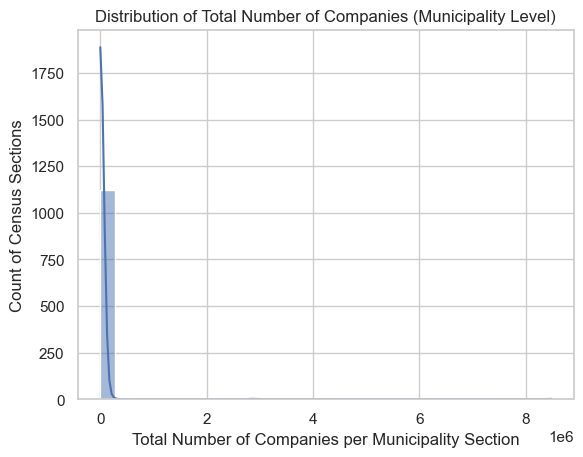

In [97]:
# Histogram for total companies at CUSEC (Census Section) level
sns.histplot(df['NumCompanies_10S'], bins=30, kde=True)
plt.title("Distribution of Total Number of Companies (Municipality Level)")
plt.xlabel("Total Number of Companies per Municipality Section")
plt.ylabel("Count of Census Sections")
plt.show()

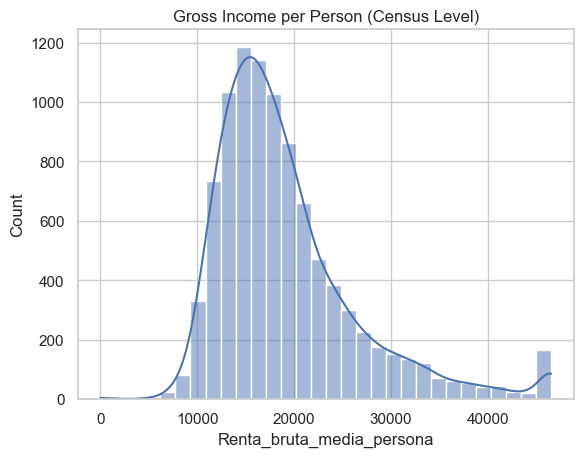

In [98]:
sns.histplot(sociodemo['Renta_bruta_media_persona'],bins=30, kde=True)
plt.title('Gross Income per Person (Census Level)')
plt.show()

**Distribution of Gross Income per Person**
- The histogram shows the distribution of Gross Income per Person across census sections.
- Right-skewed distribution: Majority falls between 12,000 - 25,000.
- A secondary peak around 45,000-50,000 suggests affluent areas.
- The KDE curve smooths the density estimate, highlighting the shape of the distribution.

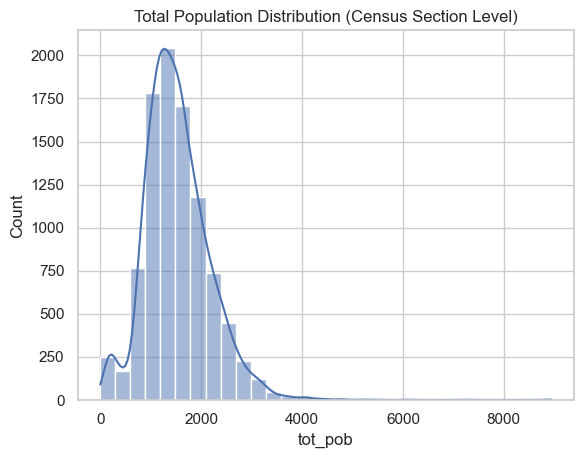

In [99]:
sns.histplot(sociodemo['tot_pob'], bins=30, kde=True)
plt.title('Total Population Distribution (Census Section Level)')
plt.show()

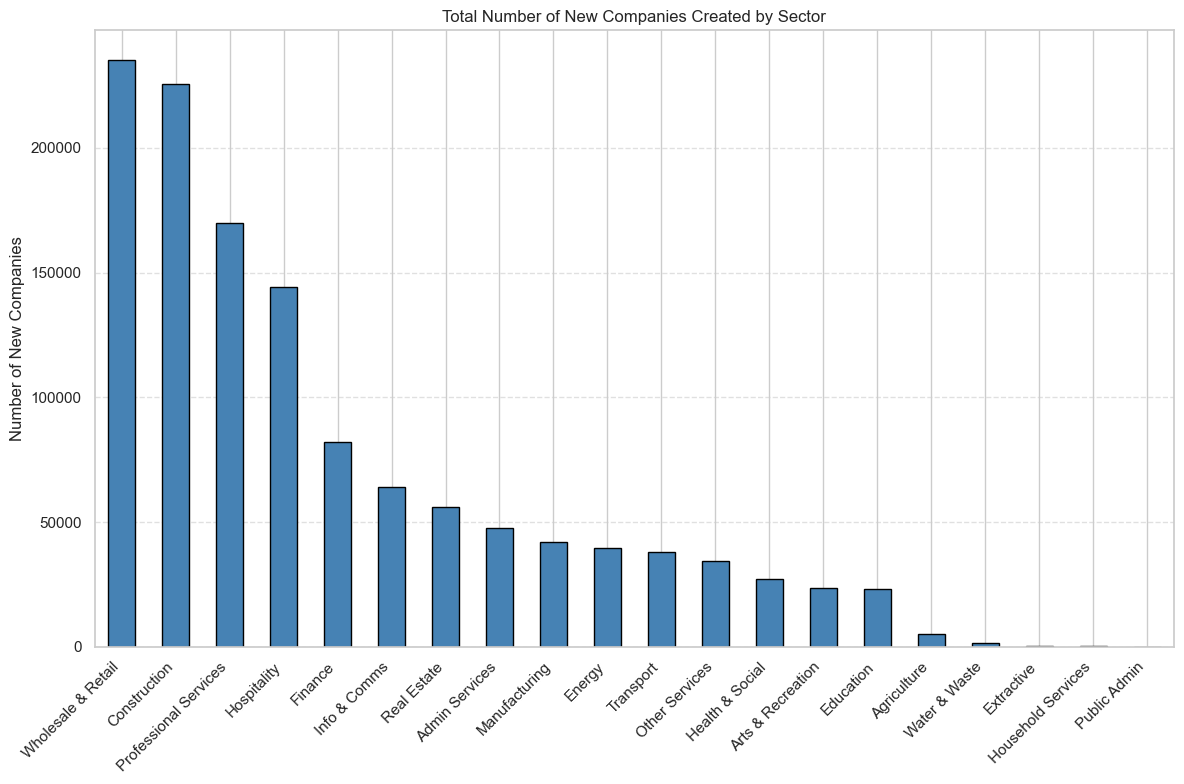

In [100]:
# Create a mapping from long names to simplified ones
rename_dict = {
    'A_AgricultureLivestockForestryAndFishing_NumCompaniesNewCreation': 'Agriculture',
    'B_ExtractiveIndustries_NumCompaniesNewCreation': 'Extractive',
    'C_ManufacturingIndustry_NumCompaniesNewCreation': 'Manufacturing',
    'D_ElectricityGasSteamAndAirConditioningSupply_NumCompaniesNewCreation': 'Energy',
    'E_WaterSupplySanitationWasteManagementAndDecontaminationActivities_NumCompaniesNewCreation': 'Water & Waste',
    'F_Construction_NumCompaniesNewCreation': 'Construction',
    'G_WholesaleAndRetailTradeRepairOfMotorVehiclesAndMotorcycles_NumCompaniesNewCreation': 'Wholesale & Retail',
    'H_TransportationAndStorage_NumCompaniesNewCreation': 'Transport',
    'I_Hospitality_NumCompaniesNewCreation': 'Hospitality',
    'J_InformationAndCommunications_NumCompaniesNewCreation': 'Info & Comms',
    'K_FinancialAndInsuranceActivities_NumCompaniesNewCreation': 'Finance',
    'L_RealEstateActivities_NumCompaniesNewCreation': 'Real Estate',
    'M_ProfessionalScientificAndTechnicalActivities_NumCompaniesNewCreation': 'Professional Services',
    'N_AdministrativeAndSupportServiceActivities_NumCompaniesNewCreation': 'Admin Services',
    'O_PublicAdministrationAndDefenseCompulsorySocialSecurity_NumCompaniesNewCreation': 'Public Admin',
    'P_Education_NumCompaniesNewCreation': 'Education',
    'Q_HealthcareAndSocialServicesActivities_NumCompaniesNewCreation': 'Health & Social',
    'R_ArtsEntertainmentAndRecreationActivities_NumCompaniesNewCreation': 'Arts & Recreation',
    'S_OtherServices_NumCompaniesNewCreation': 'Other Services',
    'T_HouseholdActivitiesAsEmployersOfDomesticStaffHouseholdProductionOfGoodsAndServicesForOwnUse_NumCompaniesNewCreation': 'Household Services',
    'total_NumCompaniesNewCreation': 'Total Companies'
}

# Apply renaming
business.rename(columns=rename_dict, inplace=True)

# Get relevant columns
new_company_cols = [col for col in business.columns if col in rename_dict.values()]

# Compute totals
sector_totals = business[new_company_cols].sum().sort_values(ascending=False)

# Filter out 'Total Companies'
sector_totals = sector_totals[sector_totals.index != 'Total Companies']

plt.figure(figsize=(12, 8))
sector_totals.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Total Number of New Companies Created by Sector')
plt.ylabel('Number of New Companies')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

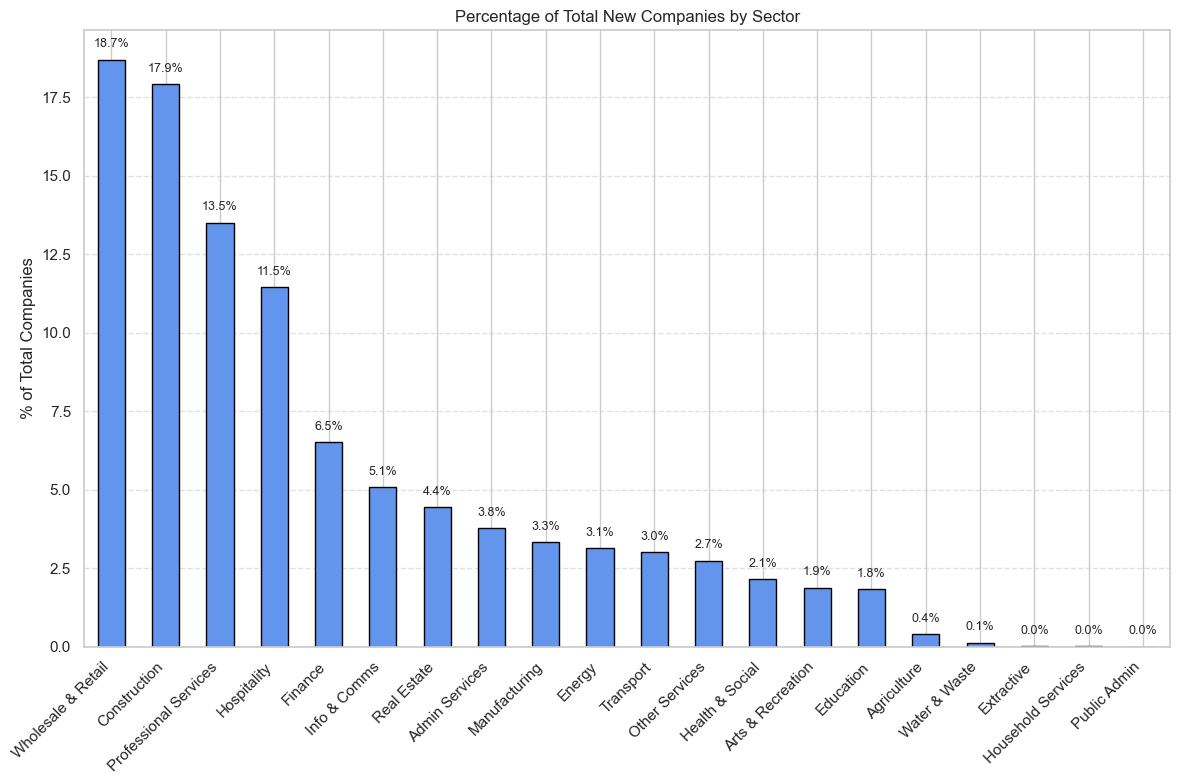

In [101]:
# Get relevant columns (already renamed)
new_company_cols = [col for col in business.columns if col in rename_dict.values()]

# Compute total new companies per sector
sector_totals = business[new_company_cols].sum().sort_values(ascending=False)

# Remove 'Total Companies' if it exists
sector_totals = sector_totals[sector_totals.index != 'Total Companies']

# Compute percentage
sector_percent = (sector_totals / sector_totals.sum()) * 100

plt.figure(figsize=(12, 8))
bars = sector_percent.plot(kind='bar', color='cornflowerblue', edgecolor='black')

plt.title('Percentage of Total New Companies by Sector')
plt.ylabel('% of Total Companies')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add percentage labels on top
for i, val in enumerate(sector_percent):
    plt.text(i, val + 0.3, f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Top Sectors for New Company Formation

The top contributors to new company formation are:

- Wholesale & Retail (18.7%)  
- Construction (17.9%)  
- Professional Services (13.5%)  
- Hospitality (11.5%)  

Together, these four sectors account for a little over 60% of all new company creations, underscoring their dominant role in shaping the economic landscape.

Correlation Insights:

Objective

The goal of this analysis is to understand the relationship between the number of bank branches (banks_total) and the presence or creation of companies across various economic sectors. Specifically, we want to identify which types of company activity correlate most strongly with bank branch density, as this may reveal strategic placement patterns and help inform future expansion plans.


Step-by-Step Plan


2. Select all company-related columns, particularly those containing "_NumCompanies".
3. Aggregate the data by Municipality using sum() to consolidate values.
4. Compute the correlation between the number of bank branches and company activity by sector.

In [102]:
# Create list of new sectors 
new_sector_cols = [
    'Agriculture', 'Extractive', 'Manufacturing', 'Energy', 'Water & Waste',
    'Construction', 'Wholesale & Retail', 'Transport', 'Hospitality',
    'Info & Comms', 'Finance', 'Real Estate', 'Professional Services',
    'Admin Services', 'Public Admin', 'Education', 'Health & Social',
    'Arts & Recreation', 'Other Services', 'Household Services'
]

aggregation_key = 'municipality' 

# Aggregate sector counts by municipality
business_agg = (
    business[new_sector_cols + [aggregation_key]]
    .groupby(aggregation_key)
    .sum()
    .reset_index()
)

# Aggregate banks_total by municipality
banks_agg = (
    df[[aggregation_key, 'banks_total']]
    .groupby(aggregation_key)
    .sum()
    .reset_index()
)

# Ensure both are strings
business_agg['municipality'] = business_agg['municipality'].astype(str)
banks_agg['municipality'] = banks_agg['municipality'].astype(str)

# Merge business and bank data on municipality
merged = pd.merge(business_agg, banks_agg, on=aggregation_key, how='inner')

# Compute Spearman correlation
correlations = (
    merged[new_sector_cols + ['banks_total']]
    .corr(method='spearman')['banks_total']
    .drop('banks_total')
    .sort_values(ascending=False)
)

# Display
print("Spearman Correlation: Sector Counts vs Bank Branches (by Municipality)")
print(correlations)

Spearman Correlation: Sector Counts vs Bank Branches (by Municipality)
Wholesale & Retail       0.720907
Construction             0.706439
Professional Services    0.659261
Hospitality              0.646531
Manufacturing            0.604064
Real Estate              0.594416
Admin Services           0.581840
Other Services           0.573532
Finance                  0.564464
Transport                0.559528
Info & Comms             0.538506
Arts & Recreation        0.513712
Health & Social          0.508678
Education                0.499873
Energy                   0.419173
Water & Waste            0.260380
Agriculture              0.216355
Extractive               0.087864
Household Services       0.072487
Public Admin                  NaN
Name: banks_total, dtype: float64


C:\Users\marta\AppData\Local\Temp\ipykernel_33376\1318904854.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')


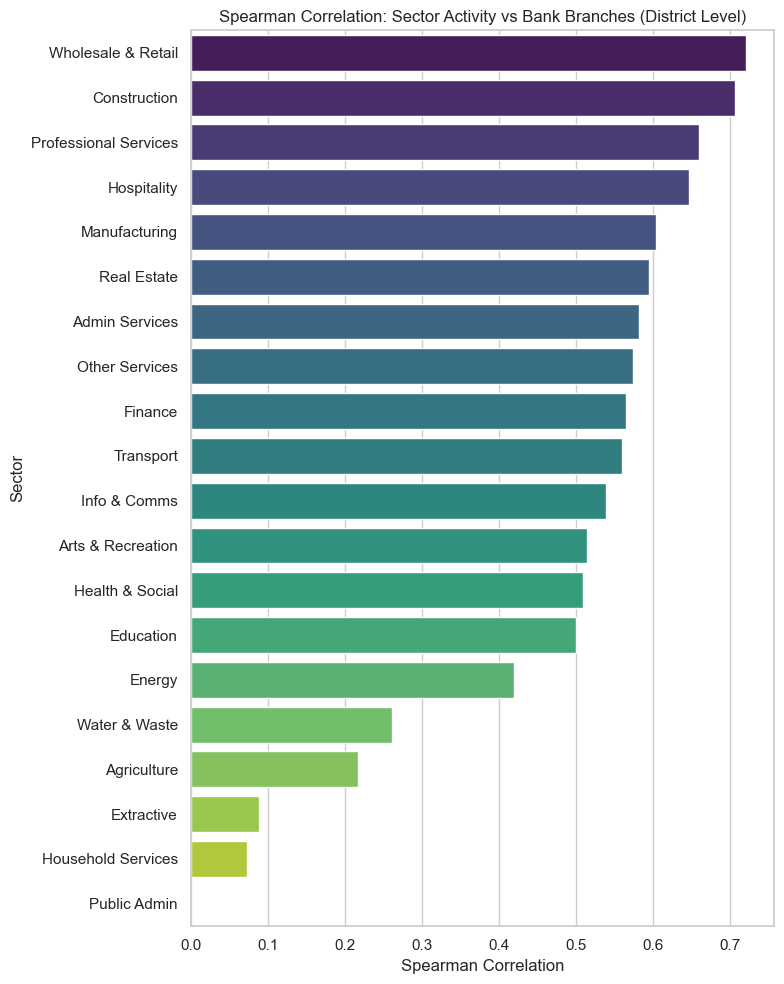

In [103]:
# Create correlation plot 
plt.figure(figsize=(8, 10))
sns.barplot(x=correlations.values, y=correlations.index, palette='viridis')
plt.title("Spearman Correlation: Sector Activity vs Bank Branches (District Level)")
plt.xlabel("Spearman Correlation")
plt.ylabel("Sector")
plt.tight_layout()
plt.show()

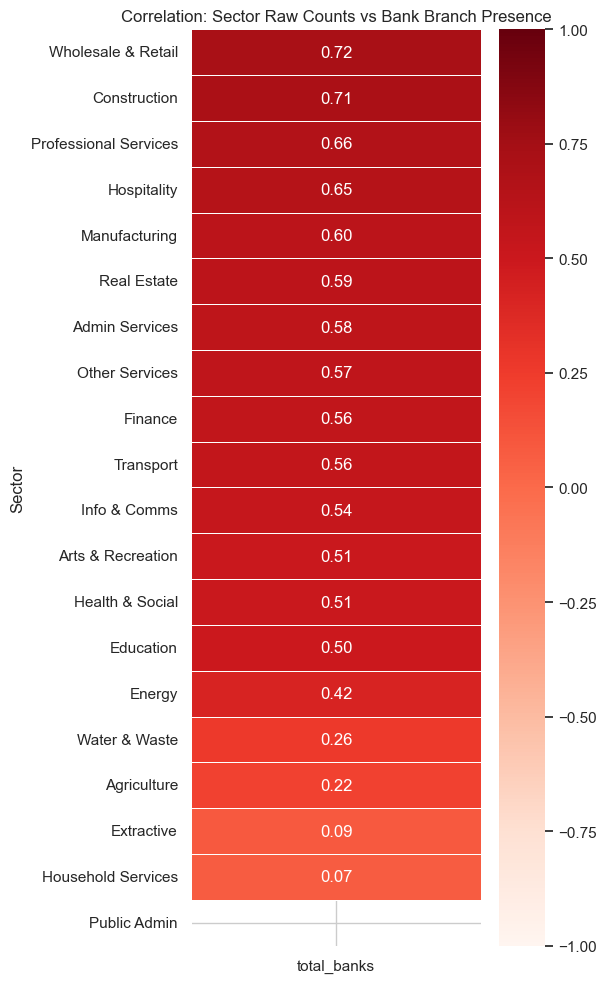

In [104]:
# Plot heatmap
plt.figure(figsize=(6, 10))
sns.heatmap(
    correlations.to_frame(name='total_banks'),
    annot=True, fmt=".2f", cmap='Reds', linewidths=0.5, vmin=-1, vmax=1
)
plt.title("Correlation: Sector Raw Counts vs Bank Branch Presence")
plt.ylabel("Sector")
plt.tight_layout()
plt.show()

In [105]:
# Get population per municipality from df
pop_agg = (
    df[['municipality', 'tot_pob']]
    .groupby('municipality')
    .sum()
    .reset_index()
)

# Ensure both are strings
merged['municipality'] = merged['municipality'].astype(str)
pop_agg['municipality'] = pop_agg['municipality'].astype(str)

# Merge population into the existing merged DataFrame
merged = pd.merge(merged, pop_agg, on='municipality', how='left')

# Calculate branch density
merged['branch_density_per_1000'] = (
    merged['banks_total'] / (merged['tot_pob'] / 1000)
)

# Generate sector density columns
density_cols = [f"{col}_per_1000" for col in new_sector_cols]
for col in new_sector_cols:
    merged[f"{col}_per_1000"] = merged[col] / (merged['tot_pob'] / 1000)

# Filter out districts with zero companies in all sectors
non_empty = merged[density_cols].sum(axis=1) > 0
filtered_df = merged[non_empty].copy()

# Compute Spearman correlation
density_corr = (
    filtered_df[density_cols + ['branch_density_per_1000']]
    .corr(method='spearman')[['branch_density_per_1000']]
    .drop('branch_density_per_1000')
    .sort_values(by='branch_density_per_1000', ascending=False)
)

# Display
print("Spearman Correlation: Company Densities (per 1000 pop) vs Branch Density (Relevant Banks Only)")
print(density_corr)

Spearman Correlation: Company Densities (per 1000 pop) vs Branch Density (Relevant Banks Only)
                                branch_density_per_1000
Wholesale & Retail_per_1000                    0.123812
Real Estate_per_1000                           0.117684
Professional Services_per_1000                 0.116244
Manufacturing_per_1000                         0.111923
Education_per_1000                             0.110437
Other Services_per_1000                        0.099068
Health & Social_per_1000                       0.098068
Transport_per_1000                             0.084612
Finance_per_1000                               0.078890
Arts & Recreation_per_1000                     0.062504
Admin Services_per_1000                        0.055628
Construction_per_1000                          0.054570
Energy_per_1000                                0.054084
Info & Comms_per_1000                          0.049383
Hospitality_per_1000                           0.041359
Water & W

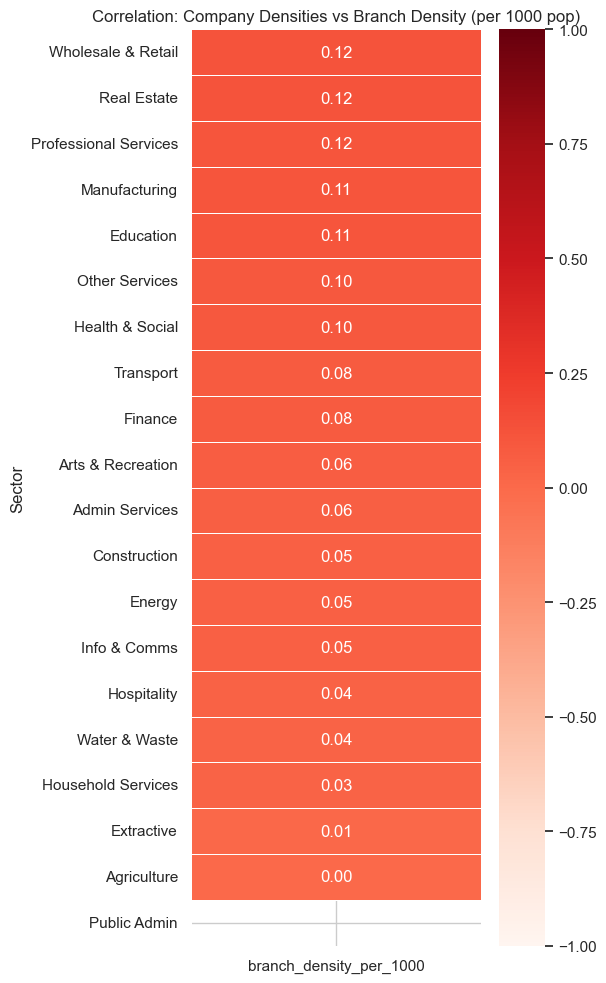

In [106]:
# Clean y-axis labels: remove "_per_1000"
cleaned_index = density_corr.index.str.replace('_per_1000', '', regex=False)
density_corr.index = cleaned_index

# Plot heatmap
plt.figure(figsize=(6, 10))
sns.heatmap(
    density_corr,
    annot=True, fmt=".2f", cmap='Reds',
    linewidths=0.5, vmin=-1, vmax=1
)

# Add labels and layout
plt.title("Correlation: Company Densities vs Branch Density (per 1000 pop)")
plt.ylabel("Sector")
plt.tight_layout()
plt.show()

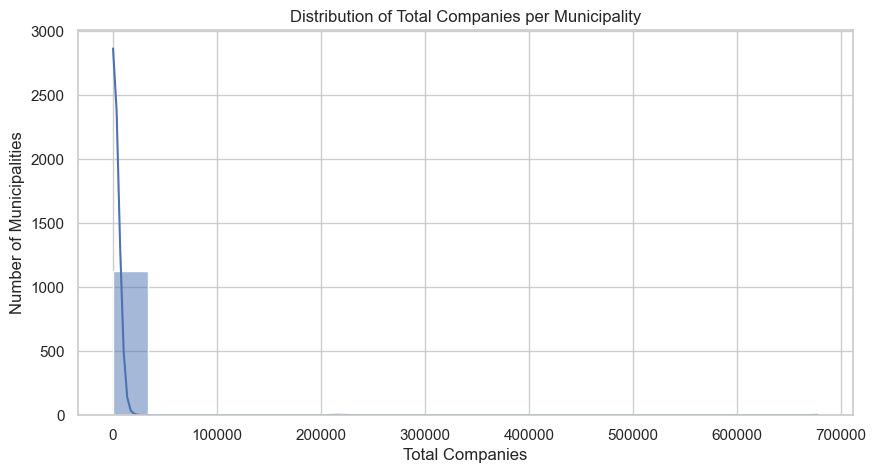

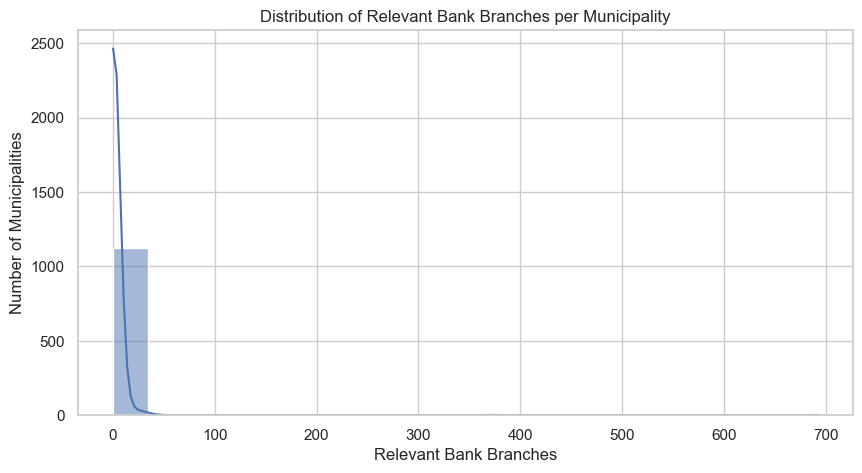

In [107]:
# Set consistent style
sns.set(style="whitegrid")

# Total Companies Histogram (unchanged)
plt.figure(figsize=(10, 5))
sns.histplot(merged[new_sector_cols].sum(axis=1), bins=20, kde=True)
plt.title("Distribution of Total Companies per Municipality")
plt.xlabel("Total Companies")
plt.ylabel("Number of Municipalities")
plt.show()

# Relevant Bank Branches Histogram 
# Aggregate NUM_BRANCHES at district level
branches_per_district = (
    merged.groupby('municipality')['banks_total'].sum().reset_index()
)

# Plot histogram for relevant banks only
plt.figure(figsize=(10, 5))
sns.histplot(branches_per_district['banks_total'], bins=20, kde=True)
plt.title("Distribution of Relevant Bank Branches per Municipality")
plt.xlabel("Relevant Bank Branches")
plt.ylabel("Number of Municipalities")
plt.show()

#### **Step 6: Feature Engineering**
---

Steps done in this section:
- Calculate ratios adjusting by population in sociodemographic variables and by the number of companies in the 10 sectors in business variables.
- Create growth rate of companies of the 10 sectors.
- Some created ratios have missing values because both the numerator and denominator of the ratio are zeros. Therefore, we impute these values ​​as zeros.

In [108]:
# Calculate ratios adjusting by population in sociodemographic variables
df['high_ratio'] = df['high'] / df['tot_pob']
df['professionals_ratio'] = df['professionals'] / df['tot_pob']
df['europeans_ratio'] = df['europeans'] / df['tot_pob']

# Calculate the growth rate of companies of the 10 sectors
df['growth_rate_10S'] = df['NumNewCompanies_10S'] / df['NumCompanies_10S']

# Calculate ratios adjusting by the number of companies in the 10 sectors in business variables
df['companies_size_ratio_10S'] = df['NumCompanies_ML_10S'] / df['NumCompanies_10S']
df['companies_profit_ratio_10S'] = df['NumCompanies_HP_10S'] / df['NumCompanies_10S']

# Some created ratios have missing values because both the numerator and denominator of the ratio are zeros. Therefore, we impute these values ​​as zeros.
df.fillna(0, inplace=True)

Clustering and score:
- Created a data frame for Madrid and Cataluña
- Scaled the features for Madrid and Cataluña
- Create composite scores (sociodemo_Score, Business_Score): These capture both absolute frequency (number of scores) and relative density (percentage). This is because the bank may be interested in both market volume and target concentration.
- Create Competitor_Score

In [109]:
# Create province column
df['municipality'] = df['municipality'].astype(str)
df['province'] = df['municipality'].apply(lambda x: 'Madrid' if x.startswith('28') else 'Cataluña')

# Create data frames for Madrid and Cataluña
df_cataluna = df[df['province'] == 'Cataluña'].copy()
df_madrid = df[df['province'] == 'Madrid'].copy()

MADRID

In [110]:
columns_to_score = [
    'high',
    'high_ratio',
    'professionals',
    'professionals_ratio',
    'europeans',
    'europeans_ratio',
    'NumCompanies_10S',
    'NumNewCompanies_10S',
    'growth_rate_10S',
    'NumCompanies_ML_10S',
    'companies_size_ratio_10S',
    'NumCompanies_HP_10S',
    'companies_profit_ratio_10S',
    'banks_total'
]

for col in columns_to_score:
    lower = df_madrid[col].quantile(0.05)
    upper = df_madrid[col].quantile(0.95)
    
    # Normalization between percentil 5 and 95
    score = (df_madrid[col] - lower) / (upper - lower) * 100
    score = score.clip(lower=0, upper=100)
    
    # Assign the new column
    df_madrid[f'{col}_score'] = score

In [111]:
# Create engineered features from scaled data 
# sociodemo_Score: Considera la frecuencia de personas de altos ingresos y profesionales y el porcentaje de ambos en la población de cada distrito  
df_madrid['sociodemo_Score'] = 0.2*(
    df_madrid['high_score'] +
    df_madrid['high_ratio_score'] +
    df_madrid['professionals_score'] +
    df_madrid['professionals_ratio_score'] + 
    df_madrid['europeans_ratio']
)

# Business_Score: 60%: Considera la frecuencia de empresas medianas y grandes de los 10 sectores y el porcentaje de ellas en el total de empresas de los 10 sectores.
# 40%: Considera la frecuencia de empresas high profit de los 10 sectores y el porcentaje de ellas en el total de empresas de los 10 sectores, además del número de nuevas empresas de los 10 sectores y la tasa de crecimiento de los 10 sectores.
df_madrid['Business_Score'] = (0.6*(df_madrid['NumCompanies_ML_10S_score'] + df_madrid['companies_size_ratio_10S_score']) + 
                        0.2*(df_madrid['NumCompanies_HP_10S_score'] + df_madrid['companies_profit_ratio_10S_score']) + 
                        0.2*(df_madrid['NumNewCompanies_10S_score'] + df_madrid['growth_rate_10S_score'])
                        )

df_madrid['Competitor_Score'] = 100 - df_madrid['banks_total_score']

#### **Step 7: Create model with HDBSCAN**
---

In [112]:
# Features to use
score_features = ['sociodemo_Score', 'Business_Score', 'Competitor_Score']

# Standardize
scaler_madrid = MinMaxScaler()
df_scaled_madrid = pd.DataFrame(
    scaler_madrid.fit_transform(df_madrid[score_features]),
    columns=[f"{col}_norm" for col in score_features],
    index=df_madrid.index
)

df_madrid = pd.concat([df_madrid, df_scaled_madrid], axis=1)

# Keep only observations with Competitor_score_norm different from 1 (without competitors)
df_madrid = df_madrid[df_madrid['Competitor_Score_norm'] != 1].copy()
df_scaled_madrid = df_scaled_madrid[df_scaled_madrid['Competitor_Score_norm'] != 1].copy()

# Clustering
clusterer_madrid = hdbscan.HDBSCAN(min_cluster_size=8, prediction_data=True)
df_madrid['hdbscan_cluster'] = clusterer_madrid.fit_predict(df_scaled_madrid)

print(df_madrid['hdbscan_cluster'].value_counts().sort_index())

df_madrid[df_madrid['hdbscan_cluster'] >= -1].groupby('hdbscan_cluster')[
    ['sociodemo_Score_norm', 'Business_Score_norm', 'Competitor_Score_norm']
].mean()

hdbscan_cluster
-1    11
 0    11
 1    84
Name: count, dtype: int64


,sociodemo_Score_norm,Business_Score_norm,Competitor_Score_norm
hdbscan_cluster,,,
-1,0.593467,0.759820,0.291866
0,0.626070,0.732926,0.081871
1,0.236812,0.195956,0.873294


In [113]:
# Compute Zone_Score using weighted business logic (manual inputs for weights)
df_madrid['Zone_Score'] = (
    0.45 * df_madrid['sociodemo_Score_norm'] +
    0.45 * df_madrid['Business_Score_norm'] +
    0.1 * df_madrid['Competitor_Score_norm']
)

# Get top 10 zones per region
top10_madrid = df_madrid.nlargest(10, 'Zone_Score')[['municipality', 'Zone_Score', 'hdbscan_cluster']]
top10_madrid.reset_index(drop=True)

,municipality,Zone_Score,hdbscan_cluster
0,28115,0.866748,-1
1,28903,0.864799,-1
2,28127,0.850769,-1
3,28006,0.799974,0
4,28005,0.734187,0
5,28022,0.702075,-1
6,28079,0.701526,0
7,28148,0.652334,-1
8,28123,0.642066,0
9,28007,0.627641,0


In [114]:
# Add municipality names column to top 10
banks = banks.rename(columns={'MUNICIPALITY': 'municipality_name'})
municipality_map = banks[['municipality', 'municipality_name']].drop_duplicates()
top10_madrid['municipality'] = top10_madrid['municipality'].astype(str)
municipality_map['municipality'] = municipality_map['municipality'].astype(str)

top10_madrid2 = top10_madrid.merge(
    municipality_map,
    on='municipality',
    how='left'
)
top10_madrid2 = top10_madrid2.nlargest(10, 'Zone_Score')[['municipality', 'municipality_name', 'Zone_Score', 'hdbscan_cluster']]
top10_madrid2.reset_index(drop=True)

,municipality,municipality_name,Zone_Score,hdbscan_cluster
0,28115,Pozuelo de Alarcón,0.866748,-1
1,28903,Tres Cantos,0.864799,-1
2,28127,"Matas, Las",0.850769,-1
3,28127,"Rozas de Madrid, Las",0.850769,-1
4,28006,Alcobendas,0.799974,0
5,28005,Alcalá de Henares,0.734187,0
6,28022,Boadilla del Monte,0.702075,-1
7,28079,Ajalvir,0.701526,0
8,28079,Boadilla del Monte,0.701526,0
9,28079,Estremera,0.701526,0


CATALUÑA

In [115]:
columns_to_score = [
    'high',
    'high_ratio',
    'professionals',
    'professionals_ratio',
    'europeans',
    'europeans_ratio',
    'NumCompanies_10S',
    'NumNewCompanies_10S',
    'growth_rate_10S',
    'NumCompanies_ML_10S',
    'companies_size_ratio_10S',
    'NumCompanies_HP_10S',
    'companies_profit_ratio_10S',
    'banks_total'
]

for col in columns_to_score:
    lower = df_cataluna[col].quantile(0.05)
    upper = df_cataluna[col].quantile(0.95)
    
    # Normalize between 5 and 95
    score = (df_cataluna[col] - lower) / (upper - lower) * 100
    score = score.clip(lower=0, upper=100)
    
    # Assing new column
    df_cataluna[f'{col}_score'] = score

In [116]:
# Create engineered features from scaled data 
# sociodemo_Score: Considera la frecuencia de personas de altos ingresos y profesionales y el porcentaje de ambos en la población de cada distrito  
df_cataluna['sociodemo_Score'] = 0.2*(
    df_cataluna['high_score'] +
    df_cataluna['high_ratio_score'] +
    df_cataluna['professionals_score'] +
    df_cataluna['professionals_ratio_score'] +
    df_cataluna['europeans_ratio']
)

# Business_Score: 60%: Considera la frecuencia de empresas medianas y grandes de los 10 sectores y el porcentaje de ellas en el total de empresas de los 10 sectores.
# 40%: Considera la frecuencia de empresas high profit de los 10 sectores y el porcentaje de ellas en el total de empresas de los 10 sectores, además del número de nuevas empresas de los 10 sectores y la tasa de crecimiento de los 10 sectores.
df_cataluna['Business_Score'] = (0.6*(df_cataluna['NumCompanies_ML_10S_score'] + df_cataluna['companies_size_ratio_10S_score']) + 
                        0.2*(df_cataluna['NumCompanies_HP_10S_score'] + df_cataluna['companies_profit_ratio_10S_score']) + 
                        0.2*(df_cataluna['NumNewCompanies_10S_score'] + df_cataluna['growth_rate_10S_score'])
                        )

df_cataluna['Competitor_Score'] = 100 - df_cataluna['banks_total_score']

In [117]:
# Features a usar
score_features = ['sociodemo_Score', 'Business_Score', 'Competitor_Score']

# Estandarizar
scaler_cataluna = MinMaxScaler()
df_scaled_cataluna = pd.DataFrame(
    scaler_cataluna.fit_transform(df_cataluna[score_features]),
    columns=[f"{col}_norm" for col in score_features],
    index=df_cataluna.index
)

df_cataluna = pd.concat([df_cataluna, df_scaled_cataluna], axis=1)

# Keep only observations with Competitor_score_norm different from 1 (without competitors)
df_cataluna = df_cataluna[df_cataluna['Competitor_Score_norm'] != 1].copy()
df_scaled_cataluna = df_scaled_cataluna[df_scaled_cataluna['Competitor_Score_norm'] != 1].copy()

# Clustering
clusterer_cataluna = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True)
df_cataluna['hdbscan_cluster'] = clusterer_cataluna.fit_predict(df_scaled_cataluna)

print(df_cataluna['hdbscan_cluster'].value_counts().sort_index())

df_cataluna[df_cataluna['hdbscan_cluster'] >= -1].groupby('hdbscan_cluster')[
    ['sociodemo_Score_norm', 'Business_Score_norm', 'Competitor_Score_norm']
].mean()

hdbscan_cluster
-1     80
 0     44
 1     12
 2    195
 3     34
 4     77
Name: count, dtype: int64


,sociodemo_Score_norm,Business_Score_norm,Competitor_Score_norm
hdbscan_cluster,,,
-1,0.528858,0.411047,0.2925
0,0.675171,0.755566,0.0000
1,0.431177,0.282395,0.2000
2,0.239309,0.162028,0.8000
3,0.244725,0.214874,0.4000
4,0.209190,0.203804,0.6000


In [118]:
# Compute Zone_Score using weighted business logic (manual inputs for weights)
df_cataluna['Zone_Score'] = (
    0.45 * df_cataluna['sociodemo_Score_norm'] +
    0.45 * df_cataluna['Business_Score_norm'] +
    0.1 * df_cataluna['Competitor_Score_norm']
)

# Get top 10 zones per region
top10_cataluna = df_cataluna.nlargest(10, 'Zone_Score')[['municipality', 'Zone_Score', 'hdbscan_cluster']]
top10_cataluna.reset_index(drop=True)

,municipality,Zone_Score,hdbscan_cluster
0,8238,0.807143,-1
1,8205,0.806855,-1
2,8221,0.792980,-1
3,8266,0.748298,0
4,8217,0.745393,0
5,8019,0.738370,0
6,8298,0.724730,0
7,17079,0.720864,0
8,8260,0.716966,-1
9,8077,0.706064,0


In [119]:
top10_cataluna['municipality'] = top10_cataluna['municipality'].astype(str)

top10_cataluna2 = top10_cataluna.merge(
    municipality_map,
    on='municipality',
    how='left'
)
top10_cataluna2 = top10_cataluna2.nlargest(10, 'Zone_Score')[['municipality', 'municipality_name', 'Zone_Score', 'hdbscan_cluster']]
top10_cataluna2.reset_index(drop=True)

,municipality,municipality_name,Zone_Score,hdbscan_cluster
0,8238,Sant Quirze del Vallés,0.807143,-1
1,8205,Sant Cugat del Vallés,0.806855,-1
2,8221,Sant Just Desvern,0.792980,-1
3,8266,Bellaterra,0.748298,0
4,8266,Cerdanyola del Vallés,0.748298,0
5,8217,Sant Joan Despí,0.745393,0
6,8019,Barcelona,0.738370,0
7,8019,"Hospitalet de Llobregat, L'",0.738370,0
8,8298,Vic,0.724730,0
9,17079,Girona,0.720864,0


#### **Step 8: Maps**
---

In [120]:
print(df.columns)

Index(['municipality', 'tot_pob', 'high', 'professionals', 'europeans',
       'nse_municip', 'NumCompanies_10S', 'NumNewCompanies_10S',
       'NumCompanies_ML_10S', 'NumCompanies_HP_10S', 'banks_BBVA',
       'banks_Bankinter', 'banks_CaixaBank', 'banks_Sabadell',
       'banks_Santander', 'banks_total', 'high_ratio', 'professionals_ratio',
       'europeans_ratio', 'growth_rate_10S', 'companies_size_ratio_10S',
       'companies_profit_ratio_10S', 'province'],
      dtype='object')


In [121]:
top_distritos = df.sort_values(by='Zone_Score', ascending=False).head(10)
print(top_distritos[['district', 'Zone_Score']])

# Lista de códigos de los 10 mejores distritos
lista_top10_distritos = top_distritos['district'].tolist()
print(lista_top10_distritos)

# Asegurate de que ambos sean del mismo tipo (int o str)
df['district'] = df['district'].astype(int)
lista_top10_distritos = [int(d) for d in lista_top10_distritos]

# Crear columna 'top': 1 si está en la lista, 0 si no
df['top'] = df['district'].isin(lista_top10_distritos).astype(int)

KeyError: 'Zone_Score'

In [ ]:
df['cluster'] = np.where(df['hdbscan_cluster'] == -1, 1, 0)

In [ ]:
census = gpd.read_file("census.gpkg")
df['district'] = df['district'].astype(str)
# Realizar la unión manteniendo la geometría de 'census'
census_merged = census.merge(df, on='district', how='left')
census_merged.fillna(0, inplace=True)

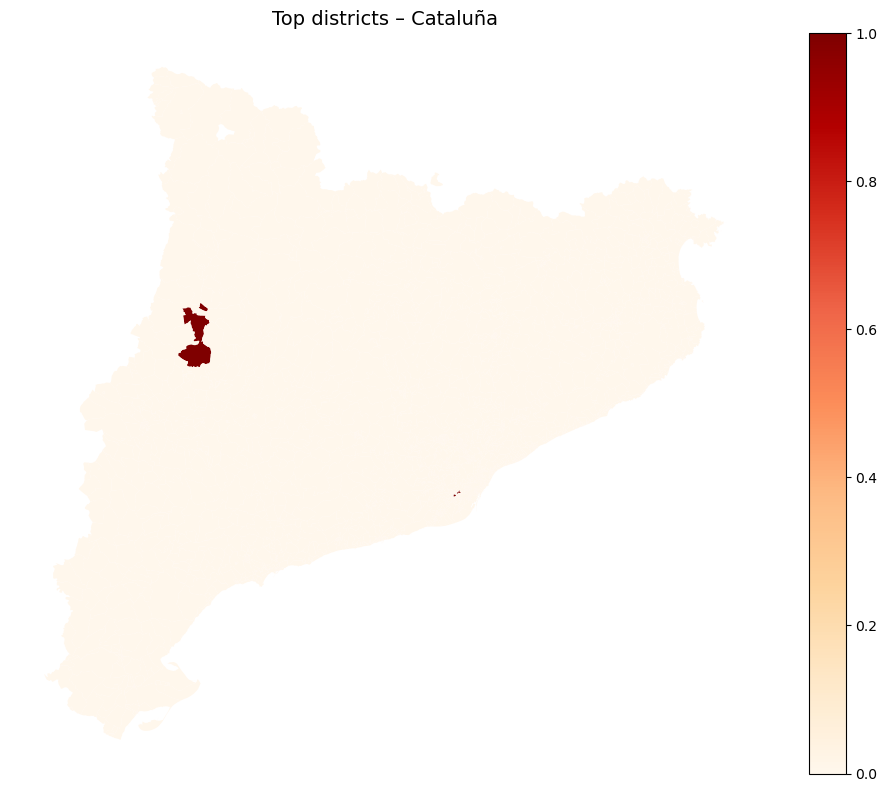

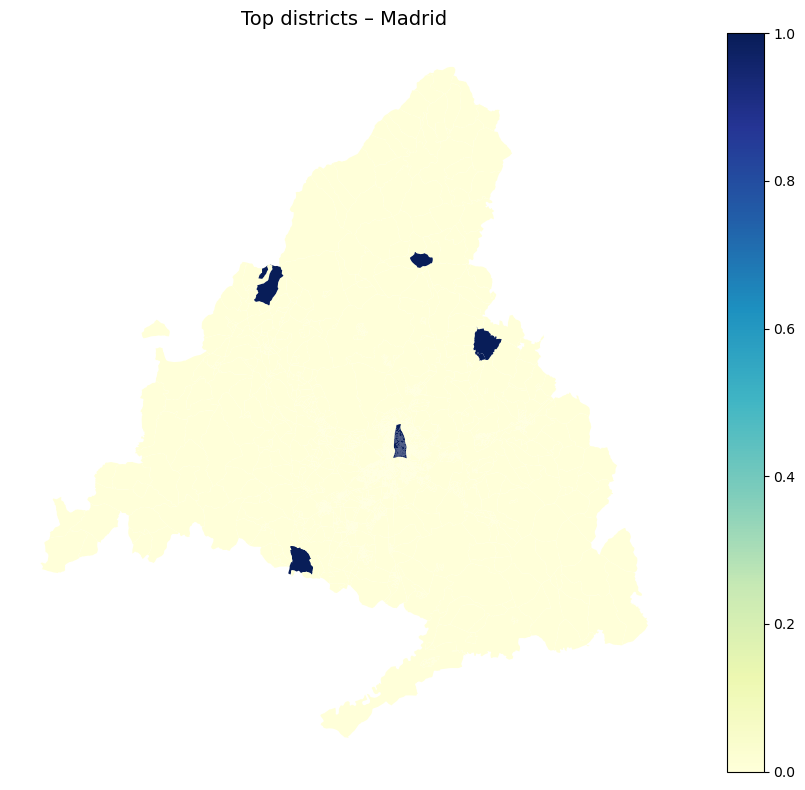

In [ ]:
# Separar por provincia
resumen_cat = census_merged[census_merged['province'] == 'Cataluña']
resumen_mad = census_merged[census_merged['province'] == 'Madrid']

# Mapa de Cataluña
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
resumen_cat.plot(column='top', cmap='OrRd', linewidth=0.1, legend=True, ax=ax)
ax.set_title("Top districts – Cataluña", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

# Mapa de Madrid
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
resumen_mad.plot(column='top', cmap='YlGnBu', linewidth=0.1, legend=True, ax=ax)
ax.set_title("Top districts – Madrid", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

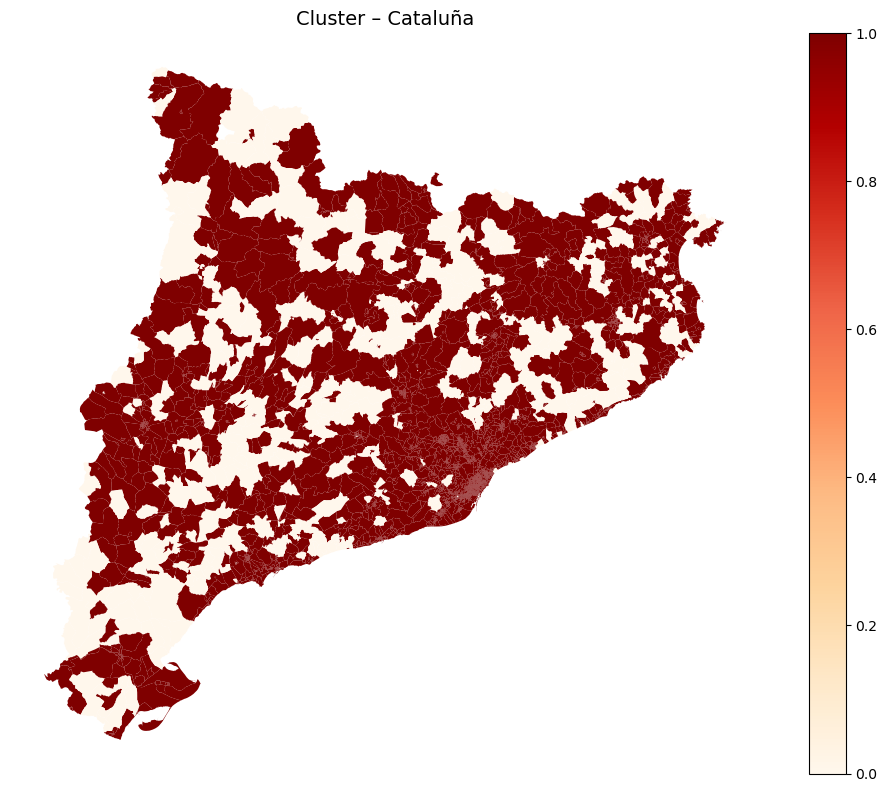

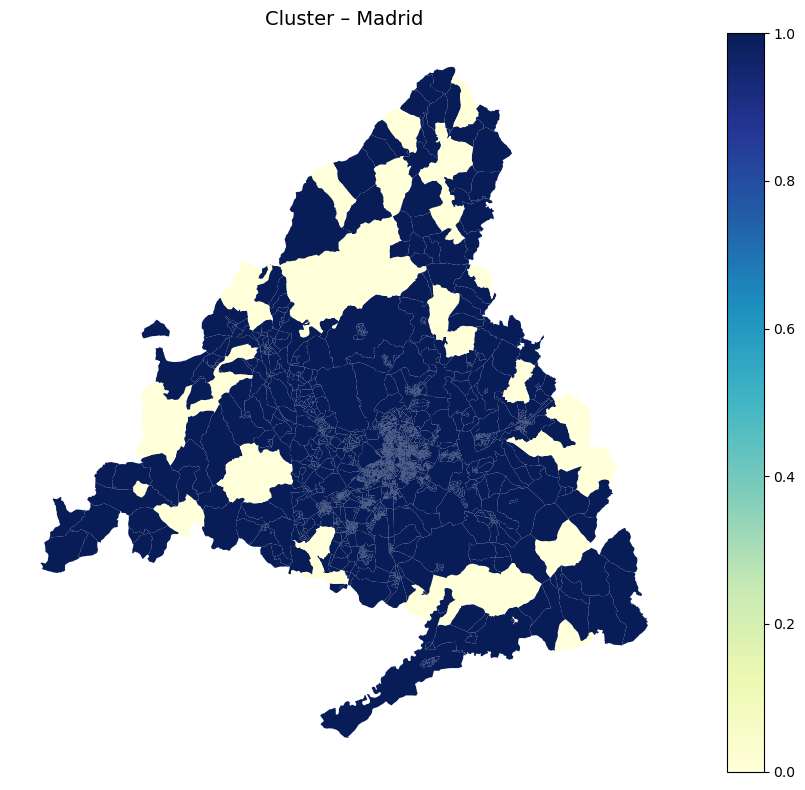

In [ ]:
# Separar por provincia
resumen_cat = census_merged[census_merged['province'] == 'Cataluña']
resumen_mad = census_merged[census_merged['province'] == 'Madrid']

# Mapa de Cataluña
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
resumen_cat.plot(column='cluster', cmap='OrRd', linewidth=0.1, legend=True, ax=ax)
ax.set_title("Cluster – Cataluña", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

# Mapa de Madrid
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
resumen_mad.plot(column='cluster', cmap='YlGnBu', linewidth=0.1, legend=True, ax=ax)
ax.set_title("Cluster – Madrid", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


#### **Step 9: Insights from competitor analysis**
---

In [122]:
bank_columns = [col for col in df_madrid.columns if col.startswith('banks_') and col not in ['banks_total', 'banks_total_score']]
competitor_totals_madrid = df_madrid[bank_columns].sum().sort_values(ascending=False)

In [123]:
bank_columns = [col for col in df_cataluna.columns if col.startswith('banks_') and col not in ['banks_total', 'banks_total_score']]
competitor_totals_cataluna = df_cataluna[bank_columns].sum().sort_values(ascending=False)

In [124]:
[col for col in df_madrid.columns if col.startswith('banks_') and col not in ['banks_total', 'banks_total_score']]

['banks_BBVA',
 'banks_Bankinter',
 'banks_CaixaBank',
 'banks_Sabadell',
 'banks_Santander']

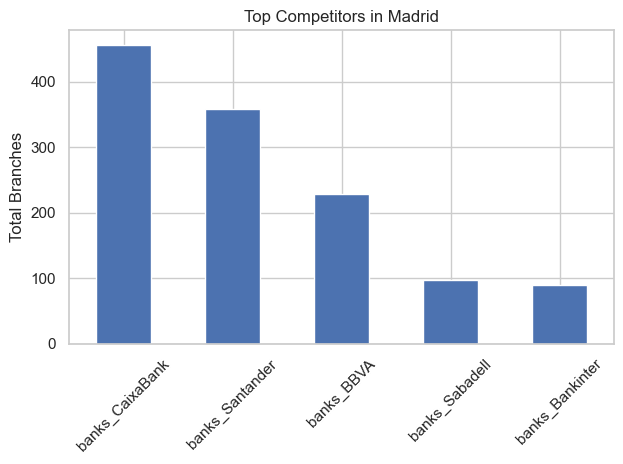

In [125]:
competitor_totals_madrid.plot(kind='bar', title='Top Competitors in Madrid')
plt.ylabel("Total Branches")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

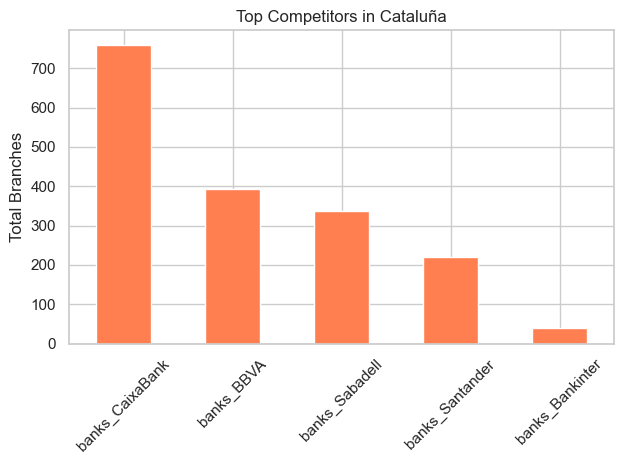

In [126]:
# Bar plot for Cataluña
competitor_totals_cataluna.plot(kind='bar', title='Top Competitors in Cataluña', color='coral')
plt.ylabel("Total Branches")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

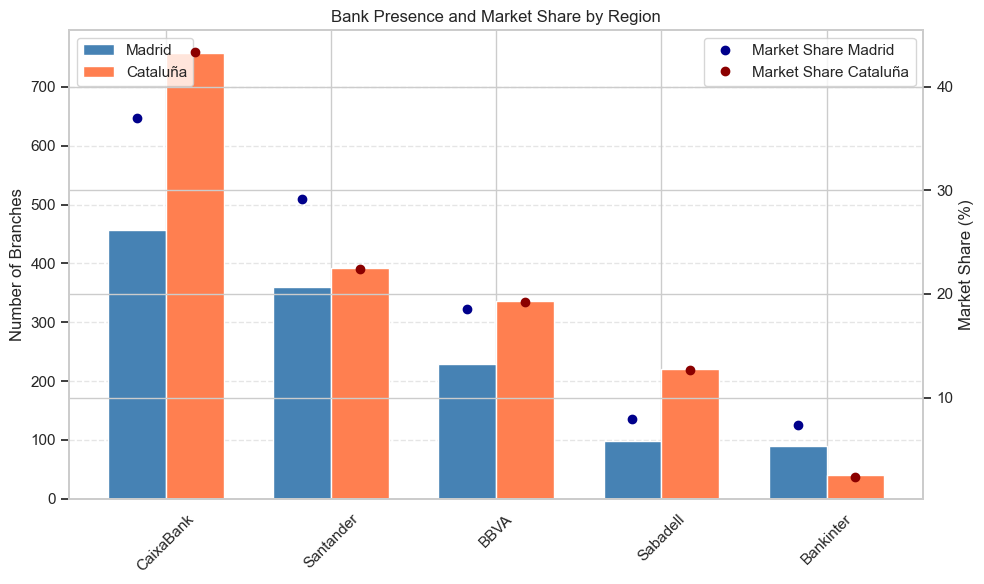

In [127]:
# Clean names and drop total rows
def clean_labels(series):
    return series.rename(lambda x: x.replace('banks_', ''))

exclude = ['banks_total', 'banks_total_score']
madrid = competitor_totals_madrid.drop([col for col in exclude if col in competitor_totals_madrid])
cataluna = competitor_totals_cataluna.drop([col for col in exclude if col in competitor_totals_cataluna])

madrid = clean_labels(madrid)
cataluna = clean_labels(cataluna)

# Market shares
madrid_pct = (madrid / madrid.sum()) * 100
cataluna_pct = (cataluna / cataluna.sum()) * 100

# Setup
labels = madrid.index
x = np.arange(len(labels))  # label locations
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart: number of branches
bars1 = ax1.bar(x - width/2, madrid.values, width, label='Madrid', color='steelblue')
bars2 = ax1.bar(x + width/2, cataluna.values, width, label='Cataluña', color='coral')
ax1.set_ylabel('Number of Branches')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45)
ax1.legend(loc='upper left')
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Line chart: market share
ax2 = ax1.twinx()
ax2.plot(x - width/2, madrid_pct.values, 'o', color='darkblue', label='Market Share Madrid')
ax2.plot(x + width/2, cataluna_pct.values, 'o', color='darkred', label='Market Share Cataluña')
ax2.set_ylabel('Market Share (%)')
ax2.legend(loc='upper right')

# Title and layout
plt.title('Bank Presence and Market Share by Region')
plt.tight_layout()
plt.show()

I will combine Madrid and Cataluna regions for training the models. I will add a label for province to flag Madrid vs Cataluna.

In [128]:
# First, ensure that both dataframes have the same structure
# You can inspect this:
print(df_madrid.columns.symmetric_difference(df_cataluna.columns))

Index([], dtype='object')


In [129]:
# Add the 'province' column to both
df_madrid['province'] = 'Madrid'
df_cataluna['province'] = 'Cataluña'

# Combine the dataframes
df_combined = pd.concat([df_madrid, df_cataluna], ignore_index=True)

# Optional sanity check
print(df_combined['province'].value_counts())
print(df_combined.shape)
df_combined.head()

province
Cataluña    442
Madrid      106
Name: count, dtype: int64
(548, 45)


,municipality,tot_pob,high,professionals,europeans,nse_municip,NumCompanies_10S,NumNewCompanies_10S,NumCompanies_ML_10S,NumCompanies_HP_10S,...,companies_profit_ratio_10S_score,banks_total_score,sociodemo_Score,Business_Score,Competitor_Score,sociodemo_Score_norm,Business_Score_norm,Competitor_Score_norm,hdbscan_cluster,Zone_Score
0,28002,4751,149.543524,1741.617279,4128,4.174049,954.0,34.0,40.0,82.0,...,100.000000,11.695906,18.579325,86.429931,88.304094,0.229819,0.468416,0.883041,1,0.402510
1,28004,10123,38.293007,3583.988163,8649,3.412468,1100.0,128.0,8.0,4.0,...,5.272727,5.847953,13.576152,29.822525,94.152047,0.167269,0.161626,0.941520,1,0.242155
2,28005,196888,6419.666709,57812.172692,167203,3.936076,104746.0,6564.0,3712.0,5897.0,...,81.632234,100.000000,50.710843,184.515177,0.000000,0.631528,1.000000,0.000000,0,0.734187
3,28006,117041,14561.594265,43447.451233,101142,5.035895,132126.0,9603.0,3015.0,5055.0,...,55.475455,100.000000,73.293354,159.396341,0.000000,0.913855,0.863866,0.000000,0,0.799974
4,28007,170296,3758.188589,51881.399910,155156,3.771680,112852.0,7579.0,2603.0,5313.0,...,68.265073,100.000000,41.697761,161.618883,0.000000,0.518846,0.875911,0.000000,0,0.627641


In [187]:
# defining features and subfeatures later to be used in the models
features = ['sociodemo_Score', 'Business_Score', 'Competitor_Score']
feature_2 = [
    'high_score',
    'high_ratio_score',
    'professionals_score',
    'professionals_ratio_score',
    'europeans_ratio',
    'growth_rate_10S',
    'NumCompanies_ML_10S',
    'companies_size_ratio_10S',
    'NumCompanies_HP_10S',
    'companies_profit_ratio_10S',
    'banks_total'
]

## 9.1. Competitor Analysis - CaixaBank

In [134]:
# understanding our target
print(df_combined['banks_CaixaBank'].describe())
print(df_combined['banks_CaixaBank'].value_counts())

count    548.000000
mean       2.215328
std       11.693261
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max      233.000000
Name: banks_CaixaBank, dtype: float64
banks_CaixaBank
1.0      449
2.0       35
3.0       14
4.0       13
0.0        8
6.0        5
5.0        5
12.0       4
8.0        4
9.0        3
10.0       3
233.0      1
11.0       1
142.0      1
7.0        1
16.0       1
Name: count, dtype: int64


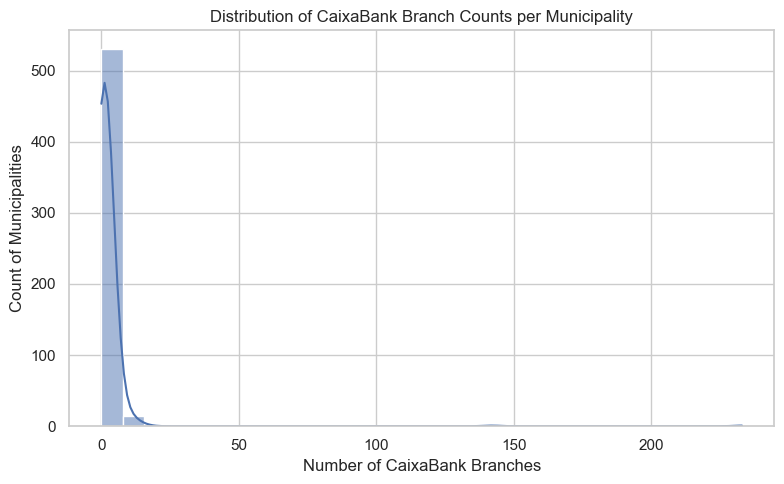

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df_combined['banks_CaixaBank'], bins=30, kde=True)
plt.title("Distribution of CaixaBank Branch Counts per Municipality")
plt.xlabel("Number of CaixaBank Branches")
plt.ylabel("Count of Municipalities")
plt.tight_layout()
plt.show()

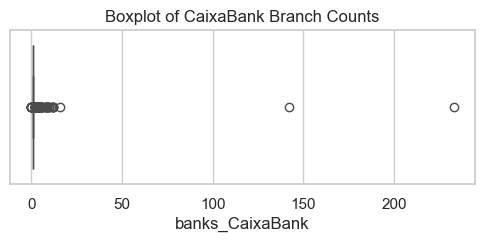

In [150]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=df_combined['banks_CaixaBank'])
plt.title("Boxplot of CaixaBank Branch Counts")
plt.show()

The target (banks_CaixaBank) is clearly right-skewed count data:

- The median is 1.

- Most values are 1 or 0 (very sparse).

- A few outliers go above 200.

We have to take this into consideration when modeling.

We will train a **Gradient Boosting Classifier** to predict the level of CaixaBank presence in municipalities, categorized into four classes:

- `none`: 0 branches  
- `low`: 1–2 branches  
- `medium`: 3–9 branches  
- `high`: ≥10 branches

In [151]:
# create new target - we make it a multiclass classification problem instead
def classify_branch_level(x):
    if x == 0:
        return 'none'
    elif x <= 2:
        return 'low'
    elif x <= 9:
        return 'medium'
    else:
        return 'high'

df_combined['caixabank_level'] = df_combined['banks_CaixaBank'].apply(classify_branch_level)

# Check distribution
print(df_combined['caixabank_level'].value_counts())

caixabank_level
low       484
medium     45
high       11
none        8
Name: count, dtype: int64


In [177]:
# Prepare features and target
X = df_combined[features]
y_raw = df_combined['caixabank_level']

# Encode target labels
le = LabelEncoder()
y = le.fit_transform(y_raw)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Train model
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

        high       0.91      0.93      0.92        97
         low       0.97      0.88      0.92        97
      medium       0.89      0.90      0.89        97
        none       0.93      0.99      0.96        97

    accuracy                           0.92       388
   macro avg       0.92      0.92      0.92       388
weighted avg       0.92      0.92      0.92       388



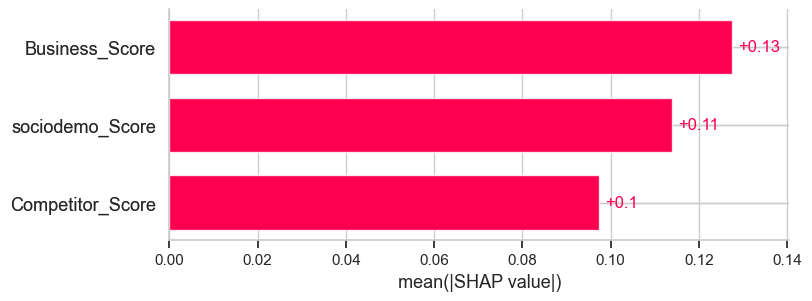

In [ ]:
# Create SHAP explainer using predict_proba
explainer = shap.Explainer(clf.predict_proba, X_train)

# Compute SHAP values for test set
shap_values = explainer(X_test)

# Plot bar chart of mean(|SHAP|) values
# Bar plot for class 0 (or any specific class index)
shap.plots.bar(shap_values[..., 0], max_display=10)

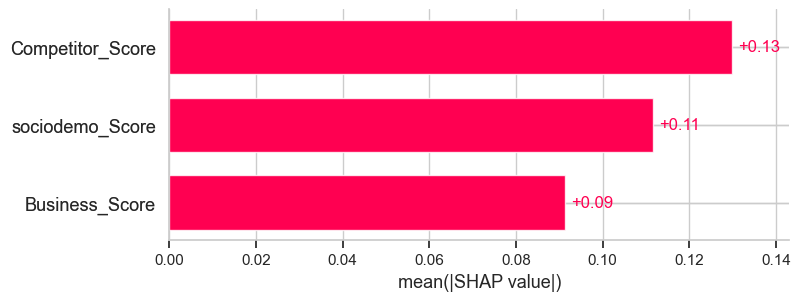

In [173]:
# Plot bar chart of mean(|SHAP|) values
# Bar plot for class 0 (or any specific class index)
shap.plots.bar(shap_values[..., 1], max_display=10)

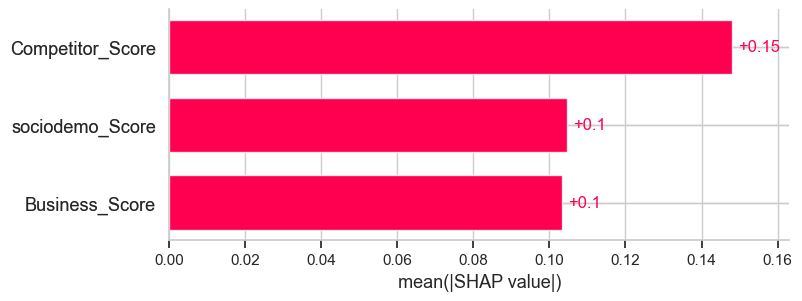

In [174]:
# Plot bar chart of mean(|SHAP|) values
# Bar plot for class 0 (or any specific class index)
shap.plots.bar(shap_values[..., 2], max_display=10)

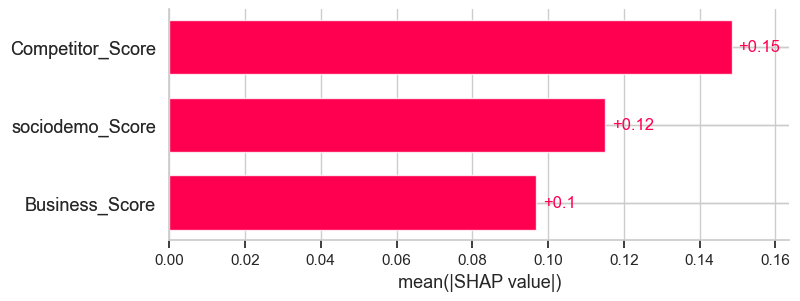

In [175]:
# Plot bar chart of mean(|SHAP|) values
# Bar plot for class 0 (or any specific class index)
shap.plots.bar(shap_values[..., 3], max_display=10)

**SHAP Bar Plot Interpretation per Class for CaixaBank**

**Class 0 – `none` (No Branches)**

- **Top Feature:** `Business_Score`
- `sociodemo_Score` also contributes notably, while `Competitor_Score` plays a lesser role.
- **Insight:** Branch absence is mainly driven by low business and sociodemographic potential — not competition. CaixaBank avoids areas with weak market fundamentals, regardless of competition levels.

---

**Class 1 – `low` (1–2 Branches)**
- **Top Feature:** `Competitor_Score`
- Suggests CaixaBank tolerates competition in smaller markets but limits its investment.
- **Insight:** Presence exists even in competitive environments, likely due to necessity rather than opportunity.

---

**Class 2 – `medium` (3–9 Branches)**
- `Competitor_Score` dominates, followed by moderate influence from `sociodemo_Score` and `Business_Score`.
- **Insight:** The decision to maintain a mid-sized presence is still influenced primarily by competitive gaps.

---

**Class 3 – `high` (10+ Branches)**
- **Top Feature:** `Competitor_Score` again leads.
- `sociodemo_Score` and `Business_Score` both contribute more evenly than in other classes.
- **Insight:** CaixaBank maximizes presence where competition is weak and the business + sociodemographic potential is strong.


In [188]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Features and target
# Correctly select those columns
X = df_combined[feature_2]  # Use double brackets to keep it as DataFrame
y_raw = df_combined['caixabank_level']

# Encode target
le = LabelEncoder()
y = le.fit_transform(y_raw)

# ✅ Split first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ✅ Then SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train model
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

        high       0.67      1.00      0.80         2
         low       0.98      0.91      0.94        97
      medium       0.64      0.78      0.70         9
        none       0.17      0.50      0.25         2

    accuracy                           0.89       110
   macro avg       0.61      0.80      0.67       110
weighted avg       0.93      0.89      0.91       110



PermutationExplainer explainer: 111it [00:16,  2.48it/s]                         


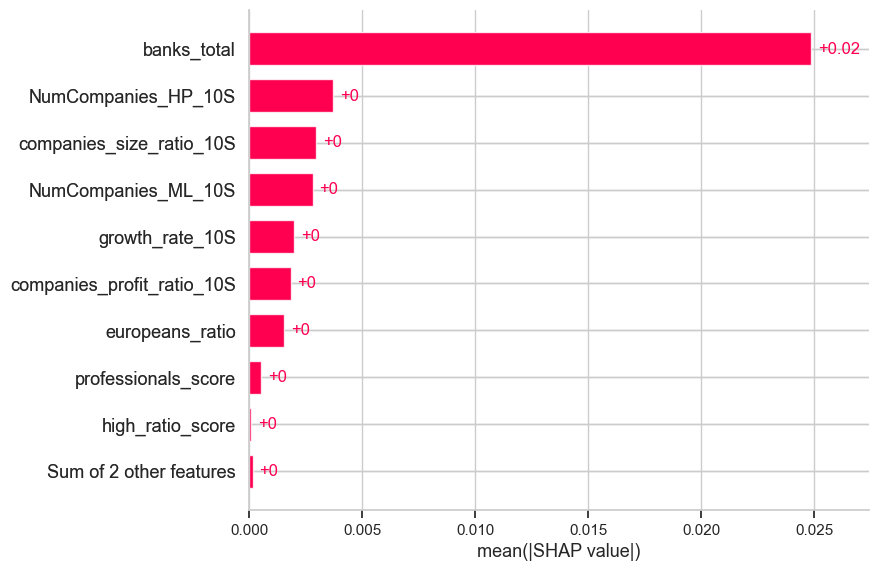

In [189]:
# Create SHAP explainer using predict_proba
explainer = shap.Explainer(clf.predict_proba, X_train)

# Compute SHAP values for test set
shap_values = explainer(X_test)

# Plot bar chart of mean(|SHAP|) values
# Bar plot for class 0 (or any specific class index)
shap.plots.bar(shap_values[..., 0], max_display=10)

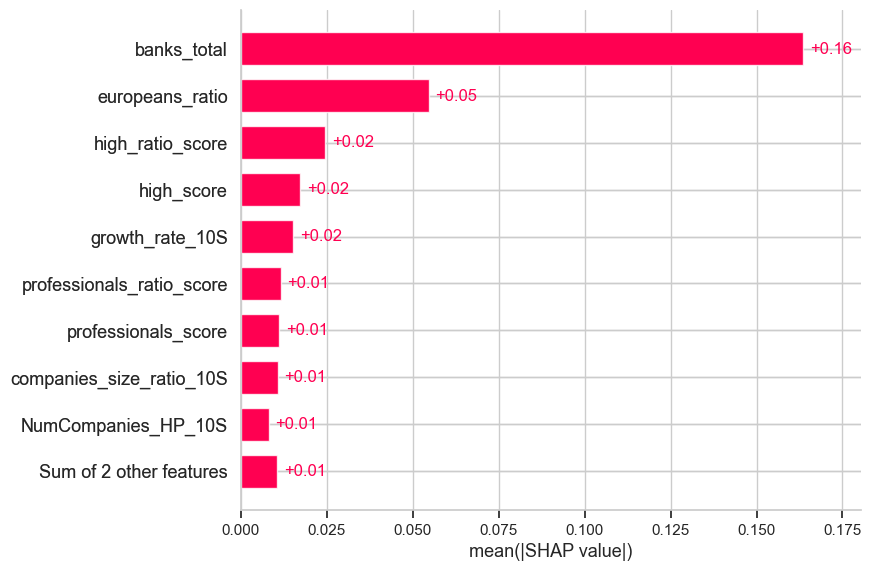

In [190]:
# Plot bar chart of mean(|SHAP|) values
# Bar plot for class 0 (or any specific class index)
shap.plots.bar(shap_values[..., 1], max_display=10)

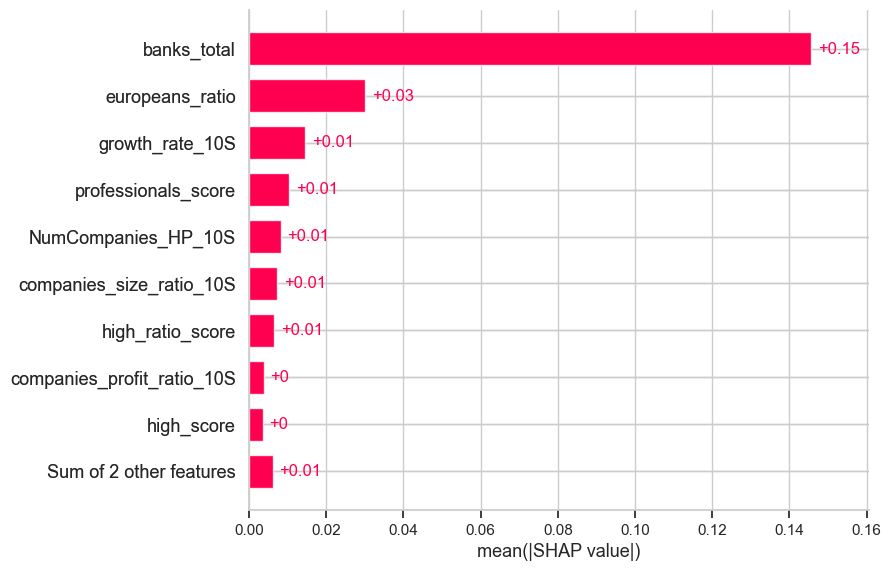

In [191]:
# Plot bar chart of mean(|SHAP|) values
# Bar plot for class 0 (or any specific class index)
shap.plots.bar(shap_values[..., 2], max_display=10)

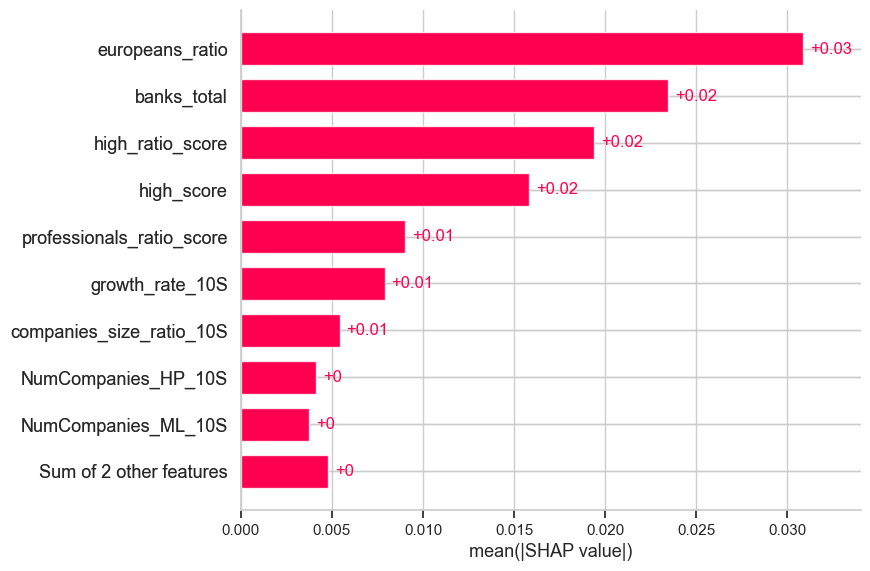

In [192]:
# Plot bar chart of mean(|SHAP|) values
# Bar plot for class 0 (or any specific class index)
shap.plots.bar(shap_values[..., 3], max_display=10)

## I have to repeat this approach for the other banks, and also split Madrid from Catuba

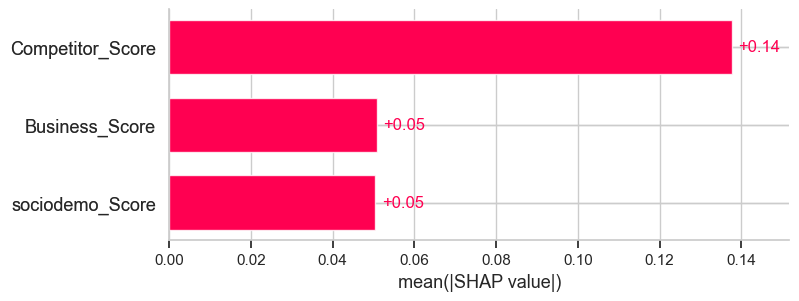

<Figure size 640x480 with 0 Axes>

In [ ]:
# -------------------------
# SHAP Explanation
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# -------------------------
# SHAP Bar Plot
shap.plots.bar(shap_values, max_display=12)
plt.tight_layout()
plt.show()

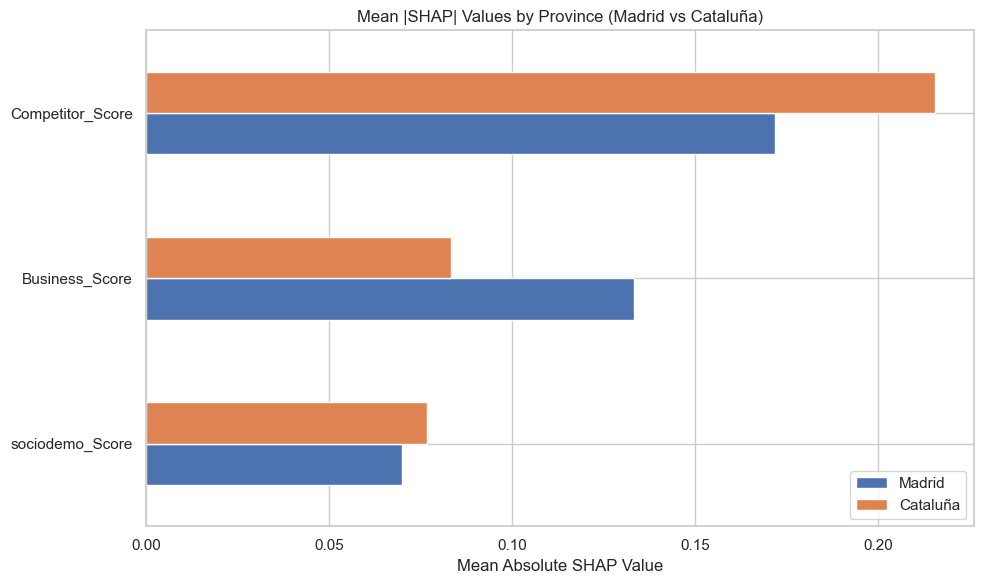

In [184]:
shap_compare.plot(kind='barh', figsize=(10, 6))
plt.title("Mean |SHAP| Values by Province (Madrid vs Cataluña)")
plt.xlabel("Mean Absolute SHAP Value")
plt.tight_layout()
plt.show()

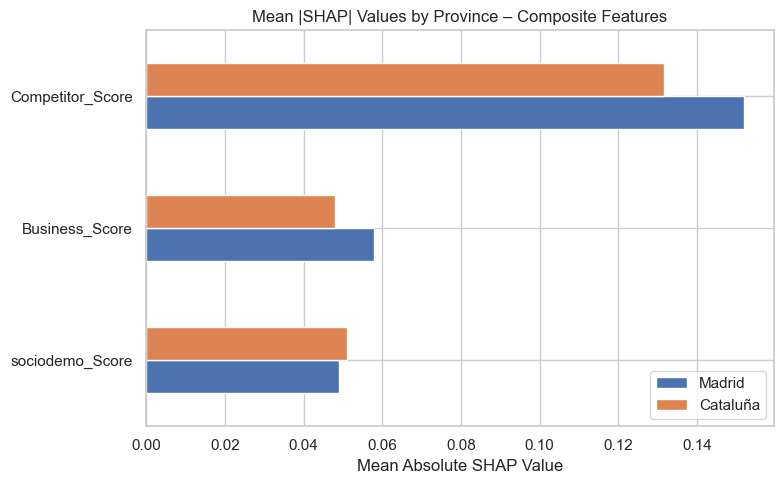

In [ ]:
# Step 1: Use only the composite features
features_only = ['sociodemo_Score', 'Business_Score', 'Competitor_Score']

# Step 2: Prepare data
X = df_combined[features_only]
y = np.log1p(df_combined['banks_CaixaBank'])

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# Step 4: Train the model (Random Forest as before)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: SHAP explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Step 6: Attach province for comparison
X_test_with_province = X_test.copy()
X_test_with_province['province'] = df_combined.loc[X_test.index, 'province']

# Step 7: Separate by region
madrid_idx = X_test_with_province[X_test_with_province['province'] == 'Madrid'].index
cataluna_idx = X_test_with_province[X_test_with_province['province'] == 'Cataluña'].index

# Step 8: Get SHAP values per region
shap_values_df = pd.DataFrame(shap_values.values, columns=features_only, index=X_test.index)
shap_values_madrid = shap_values_df.loc[madrid_idx]
shap_values_cataluna = shap_values_df.loc[cataluna_idx]

# Step 9: Compute mean |SHAP| per feature
mean_shap_madrid = shap_values_madrid.abs().mean().rename("Madrid")
mean_shap_cataluna = shap_values_cataluna.abs().mean().rename("Cataluña")

# Step 10: Plot
shap_compare = pd.concat([mean_shap_madrid, mean_shap_cataluna], axis=1)
shap_compare.plot(kind='barh', figsize=(8, 5))
plt.title("Mean |SHAP| Values by Province – Composite Features")
plt.xlabel("Mean Absolute SHAP Value")
plt.tight_layout()
plt.show()

### 9.2. Santander

In [ ]:
# ----------------------------
#  Prepare target and features
# ----------------------------
df_combined['log_target'] = np.log1p(df_combined['banks_Santander'])

X = df_combined[features]
y = df_combined['log_target']

# ----------------------------
# 3. Train-test split and model
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

R² Score: 0.449
RMSE: 0.380


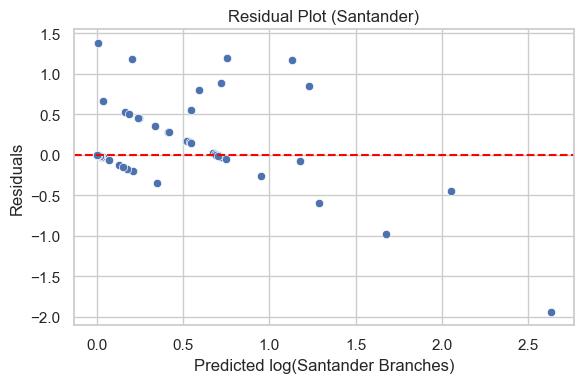

In [ ]:
# -----------------------------------
# 4. Evaluate model performance
# -----------------------------------
y_pred = model.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# Residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted log(Santander Branches)")
plt.ylabel("Residuals")
plt.title("Residual Plot (Santander)")
plt.tight_layout()
plt.show()

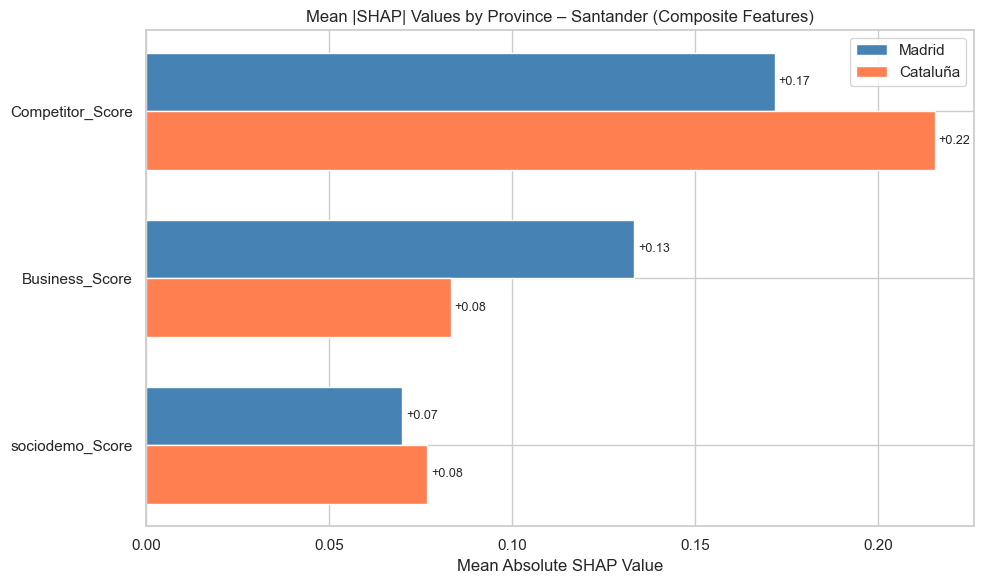

In [ ]:
# ----------------------------
# 4. Compute SHAP values
# ----------------------------
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# ----------------------------
# 5. Separate by province
# ----------------------------
X_test_with_province = X_test.copy()
X_test_with_province['province'] = df_combined.loc[X_test.index, 'province']

madrid_idx = X_test_with_province[X_test_with_province['province'] == 'Madrid'].index
cataluna_idx = X_test_with_province[X_test_with_province['province'] == 'Cataluña'].index

shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns, index=X_test.index)
shap_values_madrid = shap_values_df.loc[madrid_idx]
shap_values_cataluna = shap_values_df.loc[cataluna_idx]

# ----------------------------
# 6. Compute mean |SHAP| per feature
# ----------------------------
mean_shap_madrid = shap_values_madrid.abs().mean().rename("Madrid")
mean_shap_cataluna = shap_values_cataluna.abs().mean().rename("Cataluña")

shap_compare = pd.concat([mean_shap_madrid, mean_shap_cataluna], axis=1)

# ----------------------------
# 7. Plot with + values
# ----------------------------
def plot_shap_with_labels(shap_df, title="Mean |SHAP| Values by Province", xlabel="Mean Absolute SHAP Value"):
    shap_df_sorted = shap_df.sort_values(by='Madrid', ascending=False)
    features = shap_df_sorted.index
    values_madrid = shap_df_sorted['Madrid'].values
    values_cataluna = shap_df_sorted['Cataluña'].values

    x = np.arange(len(features))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.barh(x - width/2, values_madrid, width, label='Madrid', color='steelblue')
    bars2 = ax.barh(x + width/2, values_cataluna, width, label='Cataluña', color='coral')

    for i, (v1, v2) in enumerate(zip(values_madrid, values_cataluna)):
        ax.text(v1 + 0.001, i - width/2, f'+{v1:.2f}', va='center', fontsize=9)
        ax.text(v2 + 0.001, i + width/2, f'+{v2:.2f}', va='center', fontsize=9)

    ax.set_yticks(x)
    ax.set_yticklabels(features)
    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Show it
plot_shap_with_labels(
    shap_compare,
    title="Mean |SHAP| Values by Province – Santander (Composite Features)"
)

R² Score: 0.872
RMSE: 0.183


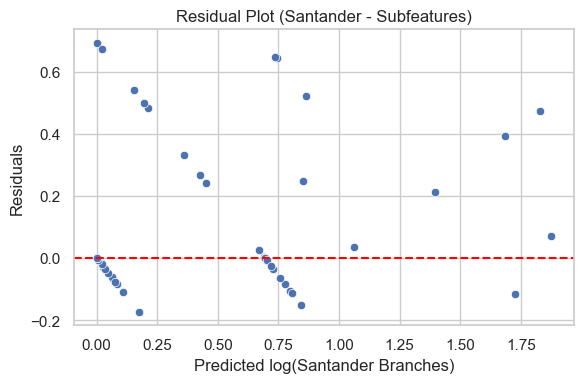

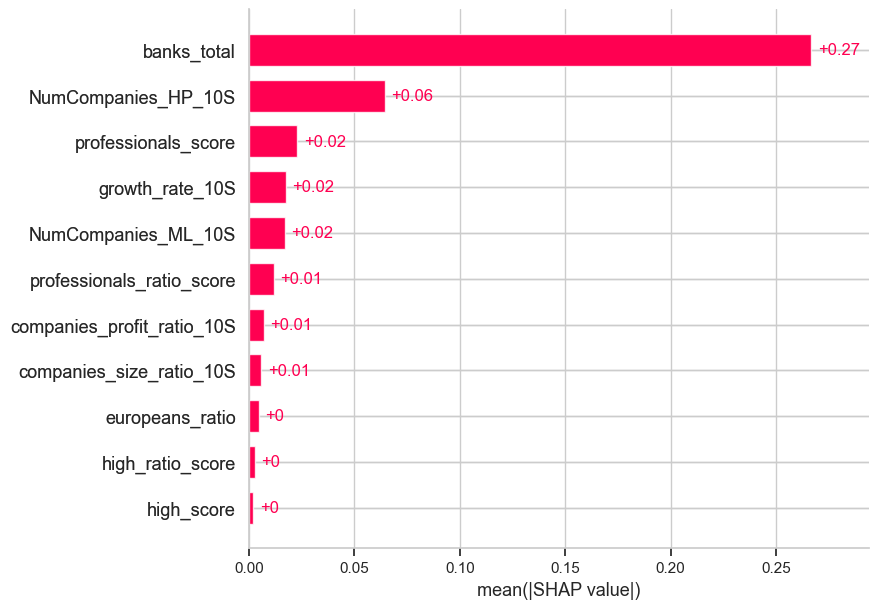

In [ ]:
# ---------------------------
# 2. Prepare target and features
# ----------------------------
df_combined['log_target'] = np.log1p(df_combined['banks_Santander'])

X = df_combined[feature_2]
y = df_combined['log_target']

# ----------------------------
# 3. Train-test split and model
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ----------------------------
# 4. Predictions and evaluation
# ----------------------------
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# Residuals
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted log(Santander Branches)")
plt.ylabel("Residuals")
plt.title("Residual Plot (Santander - Subfeatures)")
plt.tight_layout()
plt.show()

# ----------------------------
# 5. SHAP values
# ----------------------------
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# SHAP bar plot
shap.plots.bar(shap_values, max_display=12)

### 9.3. Sabadell

R² Score: 0.736
RMSE: 0.217


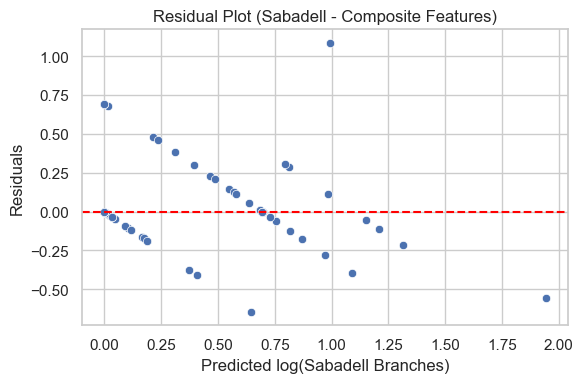

In [ ]:
# Log-transform the target
df_combined['log_target'] = np.log1p(df_combined['banks_Sabadell'])

# Prepare input and output
X = df_combined[features]
y = df_combined['log_target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted log(Sabadell Branches)")
plt.ylabel("Residuals")
plt.title("Residual Plot (Sabadell - Composite Features)")
plt.tight_layout()
plt.show()

R² Score: 0.818
RMSE: 0.180


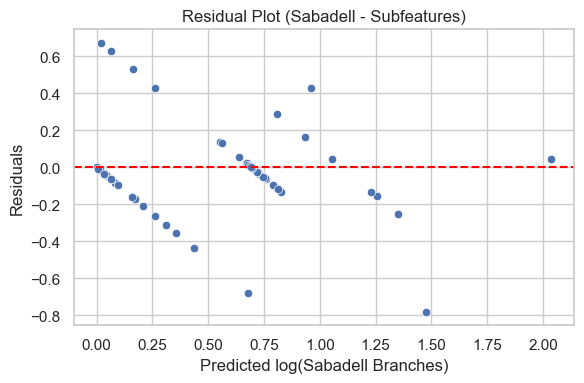

In [ ]:
# Prepare input/output with sub-features
X = df_combined[feature_2]
y = np.log1p(df_combined['banks_Sabadell'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted log(Sabadell Branches)")
plt.ylabel("Residuals")
plt.title("Residual Plot (Sabadell - Subfeatures)")
plt.tight_layout()
plt.show()

#### **Step 10: Final conclusions**
---